# 1. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ROOT_FOLDER = ".."
import sys
sys.path.append(ROOT_FOLDER)

In [3]:
import pandas as pd
import numpy as np

from pathlib import Path
import pyarrow as pa
from tqdm.autonotebook import tqdm
from datetime import datetime
import copy

from tslearn.clustering import TimeSeriesKMeans, KShape
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
import tsfel

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

C:\Users\parshin_sa2\AppData\Local\Temp\ipykernel_19568\2656187409.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Custom

In [4]:
from src.visualization.plot_stats import plot_corr_matrix, plot_grouped_hists
from src.visualization.plot_plotly import plot_time_series
from src.visualization.plot_knn_pca import plot_elbow, plot_and_get_pca, plot_tsne
from src.features.detect_peaks import get_signals_peaks
from src.features.get_fft_psd import get_fft_values, get_psd_values

### Constants

In [5]:
SEED = 42

DATA_RAW_PATH = Path("../data/raw")
DATA_INTER_PATH = Path("../data/interim")
DATA_PROC_PATH = Path("../data/processed")
PIC_EXPLORATORY_PATH = Path("../reports/figures/exploratory")

TRAIN_DATA = "X_train.parquet"
TRAIN_DATA_Y = "y_train.parquet"
METAINFO = "messages.xlsx"
METAINFO_SAVE = "metainfo"
FLOAT_TYPE = "float32"
SAVE_EXT = ".csv"

FREQ = 10
NAN_VAL = -1
NEG_VAL = -1
NAN_MARK = 3
NEG_MARK = 1
MAX_MARK = 2
NEG_TRESH = 0

GROUP_FREQ = '1Min'
GROUP_FUNC = 'mean'
GROUP_FUNC_Y = 'median'

FLOAT_TYPE = 'float32'
INT_TYPE = 'int8'

In [6]:
EQUIP_NAMES = ["ЭКСГАУСТЕР "+ str(i) for i in range(4, 10)]
FEATURE_NAMES= [
    'ТОК РОТОРА 1', 'ТОК РОТОРА 2', 'ТОК СТАТОРА', 
    'ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ',
    'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1', 'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2', 'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3', 'ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4',
    'ТЕМПЕРАТУРА МАСЛА В СИСТЕМЕ', 'ТЕМПЕРАТУРА МАСЛА В МАСЛОБЛОКЕ',
    'ВИБРАЦИЯ НА ОПОРЕ 1', 'ВИБРАЦИЯ НА ОПОРЕ 2', 'ВИБРАЦИЯ НА ОПОРЕ 3', 'ВИБРАЦИЯ НА ОПОРЕ 4', 
    'ВИБРАЦИЯ НА ОПОРЕ 3. ПРОДОЛЬНАЯ.', 'ВИБРАЦИЯ НА ОПОРЕ 4. ПРОДОЛЬНАЯ.',
    ]
NAME_EXCLUSION = ('ЭКСГАУСТЕР 4. ТОК РОТОРА 2', 'ЭКСГАУСТЕР 4. ТОК РОТОРА2')
DATETIME_COL = "DT"

In [7]:
current_stator_cols = ['ток ротора 1', 'ток ротора 2', 'ток статора']
pressure_oil = ['давление масла в системе']
bearing_temp = ['температура подшипника на опоре 1', 'температура подшипника на опоре 2', 'температура подшипника на опоре 3', 'температура подшипника на опоре 4']
oil_temp = ['температура масла в системе', 'температура масла в маслоблоке']
vibration_x = ['вибрация на опоре 1', 'вибрация на опоре 2', 'вибрация на опоре 3', 'вибрация на опоре 4']
vibration_y = ['вибрация на опоре 3. продольная.', 'вибрация на опоре 4. продольная.']

Plot params

In [8]:
# Matplotlib params
rcParams['figure.figsize'] = 24, 8
plt.set_loglevel('WARNING')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

rcParams['font.size'] = SMALL_SIZE          # controls default text sizes
rcParams['axes.titlesize'] = SMALL_SIZE     # fontsize of the axes title
rcParams['axes.labelsize'] = MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] = SMALL_SIZE    # fontsize of the tick labels
rcParams['legend.fontsize'] = SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] = BIGGER_SIZE  # fontsize of the figure title

sns.set_theme()
BASE_CONTEXT = 'fivethirtyeight'

# Plot
SHOW_ROWS = 600

# See palette
PALETTE = sns.color_palette()
print(PALETTE.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


# 2. Data uploading

In [9]:
def df_describe_info(df: pd.DataFrame,
                     percentiles: list[float] =[.002, .01, .05, .5, .95, .99],
                     ) -> None:
    display(df.info(show_counts=True))
    display(df.describe(percentiles=percentiles))
    print(f"NaNs portion: {sum(df.isna().any(axis=1)) / len(df):.3f}")

## 2.1. Train x

In [10]:
df_train_cols = [eq_name + ". " + feature_name for eq_name in EQUIP_NAMES for feature_name in FEATURE_NAMES]
df_train_cols = [NAME_EXCLUSION[1] if item == NAME_EXCLUSION[0] else item for item in df_train_cols]

df_train_schema = pa.schema([(name, FLOAT_TYPE) for name in df_train_cols] + [(DATETIME_COL, pa.timestamp('s'))])

### Common info

In [11]:
df_train = pd.read_parquet(DATA_RAW_PATH / TRAIN_DATA, schema=df_train_schema)
display(df_train.info(show_counts=True))
df_train.set_index(DATETIME_COL, drop=True, inplace=True)
df_train.rename({NAME_EXCLUSION[1]: NAME_EXCLUSION[0]}, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335034 entries, 0 to 9335033
Data columns (total 97 columns):
 #   Column                                           Non-Null Count    Dtype        
---  ------                                           --------------    -----        
 0   ЭКСГАУСТЕР 4. ТОК РОТОРА 1                       8502866 non-null  float32      
 1   ЭКСГАУСТЕР 4. ТОК РОТОРА2                        8496869 non-null  float32      
 2   ЭКСГАУСТЕР 4. ТОК СТАТОРА                        8864552 non-null  float32      
 3   ЭКСГАУСТЕР 4. ДАВЛЕНИЕ МАСЛА В СИСТЕМЕ           8635520 non-null  float32      
 4   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 1  6425379 non-null  float32      
 5   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 2  6322328 non-null  float32      
 6   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 3  6365231 non-null  float32      
 7   ЭКСГАУСТЕР 4. ТЕМПЕРАТУРА ПОДШИПНИКА НА ОПОРЕ 4  6417749 non-null  float32      
 8   ЭКСГАУСТЕР 4. ТЕМПЕРАТ

None

### Separate info by eqiupment

In [12]:
df_train_dict = {}
for equip_name in EQUIP_NAMES:
    df_train_dict[equip_name.lower()] = df_train[df_train.columns[df_train.columns.str.startswith(equip_name)]]
    df_train_dict[equip_name.lower()].columns = df_train_dict[equip_name.lower()].columns.str[len(EQUIP_NAMES[0] + ". "):].str.lower()
    df_train_dict[equip_name.lower()].index.name = df_train_dict[equip_name.lower()].index.name.lower()

Lowercase column names etc.

In [13]:
EQUIP_NAMES = [equip_name.lower() for equip_name in EQUIP_NAMES]
FEATURE_NAMES = [feature_name.lower() for feature_name in FEATURE_NAMES]
DATETIME_COL = DATETIME_COL.lower()

Dataset timerange.

In [14]:
df_train_start_end = (df_train_dict[EQUIP_NAMES[0]].index.min(), df_train_dict[EQUIP_NAMES[0]].index.max())
df_train_shape = df_train_dict[EQUIP_NAMES[0]].shape
print("Date period: ", df_train_start_end)
print("Shape: ", df_train_shape)

Date period:  (Timestamp('2019-01-16 13:21:00'), Timestamp('2021-12-31 23:59:50'))
Shape:  (9335034, 16)


### Separate info by eqiupment

In [15]:
test_eqip = EQUIP_NAMES[0]

Time frequency

In [16]:
dt_diff = (df_train_dict[test_eqip].index[1:] - df_train_dict[test_eqip].index[:-1]).seconds
print("Mean, min, max of datetime column:", np.mean(dt_diff), np.min(dt_diff), np.max(dt_diff))

Mean, min, max of datetime column: 10.0 10 10


In [17]:
# for equip_name in EQUIP_NAMES:
#     df_train_dict[equip_name] = df_train_dict[equip_name].dropna(how="all")

### Analyse one of the equipment

In [18]:
df_describe_info(df_train_dict[test_eqip])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9335034 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:50
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   ток ротора 1                       8502866 non-null  float32
 1   ток ротора 2                       8496869 non-null  float32
 2   ток статора                        8864552 non-null  float32
 3   давление масла в системе           8635520 non-null  float32
 4   температура подшипника на опоре 1  6425379 non-null  float32
 5   температура подшипника на опоре 2  6322328 non-null  float32
 6   температура подшипника на опоре 3  6365231 non-null  float32
 7   температура подшипника на опоре 4  6417749 non-null  float32
 8   температура масла в системе        6375755 non-null  float32
 9   температура масла в маслоблоке     6322877 non-null  float32
 10  вибрация на опоре 1                8532819 non-null  floa

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.
count,8.502866e+06,8.496869e+06,8.864552e+06,8.635520e+06,6.425379e+06,6.322328e+06,6.365231e+06,6.417749e+06,6.375755e+06,6.322877e+06,8.532819e+06,8.407650e+06,8.519049e+06,8.915882e+06,8.857177e+06,8.498674e+06
mean,2.856738e+02,2.859001e+02,2.571010e+02,1.310709e+02,4.745253e+01,4.616409e+01,4.263668e+01,4.491410e+01,3.632390e+01,4.200555e+01,1.273967e+00,9.407912e-01,1.179088e+00,1.591222e+00,3.105385e+00,1.229493e+00
std,6.387723e+01,6.339924e+01,4.500917e+01,2.662698e+01,7.173366e+00,7.068939e+00,6.088381e+00,6.002651e+00,8.192476e+00,5.553409e+00,4.843087e-01,3.745172e-01,8.630037e-01,3.100204e+00,1.865003e+00,7.942830e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+02,-1.000000e+02,0.000000e+00,-1.620000e+00,-8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+02,0.000000e+00,0.000000e+00
0.2%,6.076389e-01,6.076389e-01,1.736111e-01,0.000000e+00,6.490133e+00,1.055000e+01,8.112663e+00,8.842802e+00,8.112663e+00,1.217000e+01,2.777778e-02,6.000000e-02,6.000000e-02,3.000000e-02,8.000000e-02,7.000000e-02
1%,1.502893e+00,1.502893e+00,3.559028e-01,1.543210e-01,1.379000e+01,1.785000e+01,1.623000e+01,1.776675e+01,1.136000e+01,2.109294e+01,5.381944e-02,9.000000e-02,8.333333e-02,6.000000e-02,9.452160e-02,1.100000e-01
5%,2.278125e+02,2.278220e+02,2.415800e+02,1.008100e+02,3.651000e+01,3.695771e+01,3.326000e+01,3.651000e+01,1.793802e+01,3.326000e+01,3.900000e-01,4.300000e-01,2.400000e-01,6.200000e-01,8.940972e-01,3.300000e-01
50%,2.740419e+02,2.742780e+02,2.618400e+02,1.292800e+02,4.867601e+01,4.624000e+01,4.344785e+01,4.551207e+01,3.812955e+01,4.234812e+01,1.360000e+00,8.619791e-01,8.603395e-01,1.460000e+00,2.560000e+00,1.040000e+00
95%,3.812457e+02,3.812703e+02,2.837480e+02,1.702780e+02,5.579713e+01,5.678868e+01,5.029855e+01,5.210136e+01,4.672896e+01,4.964953e+01,2.013889e+00,1.670000e+00,2.780000e+00,3.488619e+00,6.790000e+00,2.800000e+00
99%,3.983150e+02,3.983150e+02,2.929840e+02,1.855300e+02,5.814079e+01,6.076390e+01,5.321910e+01,5.480559e+01,4.981179e+01,5.273234e+01,2.220000e+00,1.921875e+00,3.666088e+00,4.235243e+00,8.120000e+00,3.289062e+00


NaNs portion: 0.463


In [19]:
display(df_train_dict[test_eqip].info(show_counts=True))
display(df_train_dict[test_eqip].describe(percentiles=[.002, .01, .05, .5, .95, .99]))
print(f"NaNs portion: {sum(df_train_dict[test_eqip].isna().any(axis=1)) / len(df_train_dict[test_eqip]):.3f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9335034 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:50
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   ток ротора 1                       8502866 non-null  float32
 1   ток ротора 2                       8496869 non-null  float32
 2   ток статора                        8864552 non-null  float32
 3   давление масла в системе           8635520 non-null  float32
 4   температура подшипника на опоре 1  6425379 non-null  float32
 5   температура подшипника на опоре 2  6322328 non-null  float32
 6   температура подшипника на опоре 3  6365231 non-null  float32
 7   температура подшипника на опоре 4  6417749 non-null  float32
 8   температура масла в системе        6375755 non-null  float32
 9   температура масла в маслоблоке     6322877 non-null  float32
 10  вибрация на опоре 1                8532819 non-null  floa

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.
count,8.502866e+06,8.496869e+06,8.864552e+06,8.635520e+06,6.425379e+06,6.322328e+06,6.365231e+06,6.417749e+06,6.375755e+06,6.322877e+06,8.532819e+06,8.407650e+06,8.519049e+06,8.915882e+06,8.857177e+06,8.498674e+06
mean,2.856738e+02,2.859001e+02,2.571010e+02,1.310709e+02,4.745253e+01,4.616409e+01,4.263668e+01,4.491410e+01,3.632390e+01,4.200555e+01,1.273967e+00,9.407912e-01,1.179088e+00,1.591222e+00,3.105385e+00,1.229493e+00
std,6.387723e+01,6.339924e+01,4.500917e+01,2.662698e+01,7.173366e+00,7.068939e+00,6.088381e+00,6.002651e+00,8.192476e+00,5.553409e+00,4.843087e-01,3.745172e-01,8.630037e-01,3.100204e+00,1.865003e+00,7.942830e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+02,-1.000000e+02,0.000000e+00,-1.620000e+00,-8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+02,0.000000e+00,0.000000e+00
0.2%,6.076389e-01,6.076389e-01,1.736111e-01,0.000000e+00,6.490133e+00,1.055000e+01,8.112663e+00,8.842802e+00,8.112663e+00,1.217000e+01,2.777778e-02,6.000000e-02,6.000000e-02,3.000000e-02,8.000000e-02,7.000000e-02
1%,1.502893e+00,1.502893e+00,3.559028e-01,1.543210e-01,1.379000e+01,1.785000e+01,1.623000e+01,1.776675e+01,1.136000e+01,2.109294e+01,5.381944e-02,9.000000e-02,8.333333e-02,6.000000e-02,9.452160e-02,1.100000e-01
5%,2.278125e+02,2.278220e+02,2.415800e+02,1.008100e+02,3.651000e+01,3.695771e+01,3.326000e+01,3.651000e+01,1.793802e+01,3.326000e+01,3.900000e-01,4.300000e-01,2.400000e-01,6.200000e-01,8.940972e-01,3.300000e-01
50%,2.740419e+02,2.742780e+02,2.618400e+02,1.292800e+02,4.867601e+01,4.624000e+01,4.344785e+01,4.551207e+01,3.812955e+01,4.234812e+01,1.360000e+00,8.619791e-01,8.603395e-01,1.460000e+00,2.560000e+00,1.040000e+00
95%,3.812457e+02,3.812703e+02,2.837480e+02,1.702780e+02,5.579713e+01,5.678868e+01,5.029855e+01,5.210136e+01,4.672896e+01,4.964953e+01,2.013889e+00,1.670000e+00,2.780000e+00,3.488619e+00,6.790000e+00,2.800000e+00
99%,3.983150e+02,3.983150e+02,2.929840e+02,1.855300e+02,5.814079e+01,6.076390e+01,5.321910e+01,5.480559e+01,4.981179e+01,5.273234e+01,2.220000e+00,1.921875e+00,3.666088e+00,4.235243e+00,8.120000e+00,3.289062e+00


NaNs portion: 0.463


* Many NaNs - 0,463. Some parameters have more null, e.g. all temperatures
* Also "ток статора" имеет очень высокие значения (600А), "давление масла в системе" (4 избыт. атм.?), "температура подшипника" 486 C, вибрации на опорах (на опорах 1 и 2 - выше 2, на 3 и 4 - 3,5; продольные - 3-8)
* Negative values looks anomalies

NaNs in one row

In [20]:
print("NaNs in one row:")
for col in df_train_dict[test_eqip].columns:
    nans_count = df_train_dict[test_eqip][col].isnull().astype(int).groupby(df_train_dict[test_eqip][col].notnull().astype(int).cumsum()).sum()
    print(f"Column {col} in hours {nans_count.max() * FREQ / 60 / 60:.1f} hours and {nans_count.max()} counts")

NaNs in one row:
Column ток ротора 1 in hours 232.3 hours and 83630 counts
Column ток ротора 2 in hours 232.3 hours and 83630 counts
Column ток статора in hours 232.3 hours and 83630 counts
Column давление масла в системе in hours 232.3 hours and 83630 counts
Column температура подшипника на опоре 1 in hours 232.3 hours and 83630 counts
Column температура подшипника на опоре 2 in hours 232.3 hours and 83630 counts
Column температура подшипника на опоре 3 in hours 232.3 hours and 83630 counts
Column температура подшипника на опоре 4 in hours 232.3 hours and 83631 counts
Column температура масла в системе in hours 232.3 hours and 83637 counts
Column температура масла в маслоблоке in hours 232.3 hours and 83636 counts
Column вибрация на опоре 1 in hours 232.3 hours and 83630 counts
Column вибрация на опоре 2 in hours 232.3 hours and 83630 counts
Column вибрация на опоре 3 in hours 232.3 hours and 83630 counts
Column вибрация на опоре 4 in hours 232.3 hours and 83630 counts
Column вибрация

One of the periond have NaNs during 232 hours. Without such case (when all NaNs) NaNs in row ~ 30 hours.

### Separate vibration data

In [21]:
df_train_vib_dict = {}
for equip_name in EQUIP_NAMES:
    df_equip_ = df_train_dict[equip_name][vibration_x + vibration_y].copy()
    df_equip_[df_equip_.isnull()] = NAN_VAL
    df_equip_[df_equip_ < NEG_TRESH] = NEG_VAL
    df_train_vib_dict[equip_name] = df_equip_

### Aggreagte data

In [22]:
for equip_name in EQUIP_NAMES:
    df_train_dict[equip_name] = df_train_dict[equip_name].groupby(pd.Grouper(freq=GROUP_FREQ)).aggregate(GROUP_FUNC)

Was 9335034, now 1555839 rows

### Save NaN's positions and doubtful values

* `df_train_state_dict` - store indicators of bad values or __NaNs__
* for `df_train_dict` - replace __NaNs__ and __negative values__

In [23]:
df_train_state_dict = {equip_name: pd.DataFrame(0, index=df_train_dict[equip_name].index, columns=df_train_dict[equip_name].columns, dtype=np.int8) for equip_name in EQUIP_NAMES}

for equip_name in EQUIP_NAMES:
    df_train_state_dict[equip_name][df_train_dict[equip_name].isnull()] = NAN_MARK
    df_train_state_dict[equip_name][df_train_dict[equip_name] < NEG_TRESH] = NEG_MARK
    df_train_dict[equip_name][df_train_dict[equip_name].isnull()] = NAN_VAL
    df_train_dict[equip_name][df_train_dict[equip_name] < NEG_TRESH] = NEG_VAL

In [24]:
df_describe_info(df_train_dict[test_eqip])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555839 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   ток ротора 1                       1555839 non-null  float32
 1   ток ротора 2                       1555839 non-null  float32
 2   ток статора                        1555839 non-null  float32
 3   давление масла в системе           1555839 non-null  float32
 4   температура подшипника на опоре 1  1555839 non-null  float32
 5   температура подшипника на опоре 2  1555839 non-null  float32
 6   температура подшипника на опоре 3  1555839 non-null  float32
 7   температура подшипника на опоре 4  1555839 non-null  float32
 8   температура масла в системе        1555839 non-null  float32
 9   температура масла в маслоблоке     1555839 non-null  float32
 10  вибрация на опоре 1                1555839 non-nu

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.
count,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06
mean,2.718409e+02,2.718725e+02,2.458754e+02,1.259223e+02,4.033101e+01,3.905657e+01,3.558645e+01,3.798860e+01,3.071867e+01,3.500560e+01,1.190418e+00,8.777451e-01,1.113310e+00,1.596157e+00,2.995057e+00,1.158709e+00
std,8.388812e+01,8.384470e+01,6.798654e+01,3.657796e+01,1.767732e+01,1.783024e+01,1.615249e+01,1.632980e+01,1.475874e+01,1.597877e+01,6.087348e-01,4.851554e-01,9.194074e-01,9.636254e-01,1.955154e+00,8.631763e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
0.2%,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
1%,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
5%,1.714445e+00,1.508727e+00,2.604167e-01,6.963735e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.075000e-01,1.360000e-01,1.125000e-01,1.000000e-01,1.216667e-01,1.850000e-01
50%,2.524988e+02,2.525596e+02,2.611915e+02,1.280792e+02,4.664500e+01,4.502500e+01,4.162172e+01,4.379338e+01,3.563001e+01,4.084595e+01,1.336667e+00,8.433333e-01,8.383333e-01,1.428418e+00,2.501667e+00,9.969457e-01
95%,3.791037e+02,3.791037e+02,2.834238e+02,1.698699e+02,5.517967e+01,5.570556e+01,4.955489e+01,5.151500e+01,4.596925e+01,4.899301e+01,1.998587e+00,1.655000e+00,2.753940e+00,3.386936e+00,6.760000e+00,2.767819e+00
99%,3.979829e+02,3.979830e+02,2.927658e+02,1.852080e+02,5.786679e+01,5.949000e+01,5.279994e+01,5.435489e+01,4.926043e+01,5.232500e+01,2.212050e+00,1.906473e+00,3.644895e+00,4.034119e+00,8.088997e+00,3.267162e+00


NaNs portion: 0.000


In [25]:
df_describe_info(df_train_state_dict[test_eqip])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555839 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype
---  ------                             --------------    -----
 0   ток ротора 1                       1555839 non-null  int8 
 1   ток ротора 2                       1555839 non-null  int8 
 2   ток статора                        1555839 non-null  int8 
 3   давление масла в системе           1555839 non-null  int8 
 4   температура подшипника на опоре 1  1555839 non-null  int8 
 5   температура подшипника на опоре 2  1555839 non-null  int8 
 6   температура подшипника на опоре 3  1555839 non-null  int8 
 7   температура подшипника на опоре 4  1555839 non-null  int8 
 8   температура масла в системе        1555839 non-null  int8 
 9   температура масла в маслоблоке     1555839 non-null  int8 
 10  вибрация на опоре 1                1555839 non-null  int8 
 11  вибрация 

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.
count,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06
mean,1.157819e-01,1.175983e-01,1.250027e-01,1.184988e-01,4.023578e-01,4.417250e-01,4.339016e-01,3.980592e-01,4.154144e-01,4.464794e-01,8.177774e-02,8.163891e-02,8.285176e-02,8.139853e-02,7.175871e-02,8.219424e-02
std,5.778758e-01,5.822076e-01,5.994852e-01,5.843411e-01,1.022300e+00,1.062851e+00,1.055194e+00,1.017668e+00,1.036123e+00,1.067752e+00,4.885138e-01,4.881106e-01,4.916208e-01,4.857419e-01,4.583961e-01,4.897213e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.2%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
95%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
99%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00


NaNs portion: 0.000


In [26]:
display(df_train_state_dict[test_eqip].info(show_counts=True))
display(df_train_state_dict[test_eqip].describe(percentiles=[.002, .01, .05, .5, .95, .99]))
print(f"NaNs portion: {sum(df_train_state_dict[test_eqip].isna().any(axis=1)) / len(df_train_state_dict[test_eqip]):.3f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555839 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 16 columns):
 #   Column                             Non-Null Count    Dtype
---  ------                             --------------    -----
 0   ток ротора 1                       1555839 non-null  int8 
 1   ток ротора 2                       1555839 non-null  int8 
 2   ток статора                        1555839 non-null  int8 
 3   давление масла в системе           1555839 non-null  int8 
 4   температура подшипника на опоре 1  1555839 non-null  int8 
 5   температура подшипника на опоре 2  1555839 non-null  int8 
 6   температура подшипника на опоре 3  1555839 non-null  int8 
 7   температура подшипника на опоре 4  1555839 non-null  int8 
 8   температура масла в системе        1555839 non-null  int8 
 9   температура масла в маслоблоке     1555839 non-null  int8 
 10  вибрация на опоре 1                1555839 non-null  int8 
 11  вибрация 

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.
count,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06,1.555839e+06
mean,1.157819e-01,1.175983e-01,1.250027e-01,1.184988e-01,4.023578e-01,4.417250e-01,4.339016e-01,3.980592e-01,4.154144e-01,4.464794e-01,8.177774e-02,8.163891e-02,8.285176e-02,8.139853e-02,7.175871e-02,8.219424e-02
std,5.778758e-01,5.822076e-01,5.994852e-01,5.843411e-01,1.022300e+00,1.062851e+00,1.055194e+00,1.017668e+00,1.036123e+00,1.067752e+00,4.885138e-01,4.881106e-01,4.916208e-01,4.857419e-01,4.583961e-01,4.897213e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.2%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
95%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
99%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00


NaNs portion: 0.000


### Save data

In [27]:
# for equip_name in EQUIP_NAMES:
#     df_train_dict[equip_name].to_csv(DATA_INTER_PATH / (equip_name + "_train" + SAVE_EXT))
# for equip_name in EQUIP_NAMES:
#     df_train_state_dict[equip_name].to_csv(DATA_INTER_PATH / (equip_name + "_train_idx" + SAVE_EXT))

## 2.2. Train y

In [28]:
Y_NAMES = [
    'Y_ЭКСГАУСТЕР А/М №9_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9',
    'Y_ЭКСГАУСТЕР А/М №9_МАСЛОСТАНЦИЯ ЖИДКОЙ СМАЗКИ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_КЛ1 ТР№9 ДО ЭД ЭКСГАУСТЕРА №9',
    'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_КОРПУС ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9',
    'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_РОТОР ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ТР-Р ТМ-6300-10/6 ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №2',
    'Y_ЭКСГАУСТЕР А/М №9_ГСМ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_КОЖУХ МУФТЫ ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №1',
    'Y_ЭКСГАУСТЕР А/М №9_ЗАДВИЖКА ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №9_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№9 Т.1',
    'Y_ЭКСГАУСТЕР А/М №9_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №9',
    'Y_ЭКСГАУСТЕР А/М №9_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ9 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №9_МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ.№9',
    'Y_ЭКСГАУСТЕР А/М №9_ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР.МАСЛО',
    'Y_ЭКСГАУСТЕР А/М №9_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.1',
    'Y_ЭКСГАУСТЕР А/М №9_ЭКСГАУСТЕР А/М №9',
    'Y_ЭКСГАУСТЕР А/М №9_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №9',
    'Y_ЭКСГАУСТЕР А/М №5_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_КОРПУС ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ЗАДВИЖКА ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №2',
    'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (РЕЗ.) ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.1',
    'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.3',
    'Y_ЭКСГАУСТЕР А/М №5_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №5',
    'Y_ЭКСГАУСТЕР А/М №5_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№5 Т.2',
    'Y_ЭКСГАУСТЕР А/М №5_ПОДШИПНИК ОПОРНЫЙ №1',
    'Y_ЭКСГАУСТЕР А/М №5_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №5_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №5',
    'Y_ЭКСГАУСТЕР А/М №5_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №5',
    'Y_ЭКСГАУСТЕР А/М №5_ГСМ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ЭКСГАУСТЕР А/М №5',
    'Y_ЭКСГАУСТЕР А/М №5_ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР.МАСЛО',
    'Y_ЭКСГАУСТЕР А/М №5_ТР-Р ТМ-4000-10/6 ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_КЛ1 ТР№5 ДО ЭД ЭКСГАУСТЕРА №5',
    'Y_ЭКСГАУСТЕР А/М №5_КЛ2 ТР№5 ДО ЭД ЭКСГАУСТЕРА №5',
    'Y_ЭКСГАУСТЕР А/М №5_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_РОТОР ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ.№5',
    'Y_ЭКСГАУСТЕР А/М №5_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №5',
    'Y_ЭКСГАУСТЕР А/М №5_КОЖУХ МУФТЫ ЭКСГ. №5',
    'Y_ЭКСГАУСТЕР А/М №5_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ5 ВУ2',
    'Y_ЭКСГАУСТЕР А/М №5_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2',
    'Y_ЭКСГАУСТЕР А/М №5_ДВИГАТЕЛЬ РЕЗЕРВНОГО МАСЛОНАСОСА ЭКСГ.№5',
    'Y_ЭКСГАУСТЕР А/М №5_ТСМТ-101-010-50М-200 ТЕРМОПР.ПОДШ.Т.3',
    'Y_ЭКСГАУСТЕР А/М №5_ЭКСГАУСТЕР Н-8000 А/М №5',
    'Y_ЭКСГАУСТЕР А/М №8_РОТОР ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_КОРПУС ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.3',
    'Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.4',
    'Y_ЭКСГАУСТЕР А/М №8_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5',
    'Y_ЭКСГАУСТЕР А/М №8_КЛ2 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №8_КЛ1 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №8_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2',
    'Y_ЭКСГАУСТЕР А/М №8_КОЖУХ МУФТЫ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ГСМ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ №2',
    'Y_ЭКСГАУСТЕР А/М №8_ЭКСГАУСТЕР А/М №8',
    'Y_ЭКСГАУСТЕР А/М №8_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №8_ТСМТ-101-010-50М-200 ТЕРМОПР.ПОДШ.Т.4',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛЯНЫЙ ФИЛЬТР ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ8 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ №1',
    'Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ЗАДВИЖКА ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (РЕЗ.) ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№8',
    'Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.2',
    'Y_ЭКСГАУСТЕР А/М №8_ТР-Р ТМ-6300-10/6 ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №8',
    'Y_ЭКСГАУСТЕР А/М №8_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №8',
    'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№4 Т.1',
    'Y_ЭКСГАУСТЕР А/М №4_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.1',
    'Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ЭКСГАУСТЕР А/М №4',
    'Y_ЭКСГАУСТЕР А/М №4_ЗАП. И РЕГ. АРМАТУРА ЭКСГ.№4',
    'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
    'Y_ЭКСГАУСТЕР А/М №4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
    'Y_ЭКСГАУСТЕР А/М №4_ТР-Р ТМ-4000-10/6 ЭКСГ. №4',
    'Y_ЭКСГАУСТЕР А/М №4_ТИРИСТ. ВОЗБУДИТЕЛЬ ВТ-РЭМ-400 ЭКСГ4 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №4_МАСЛОПРОВОДЫ ЭКСГ №4',
    'Y_ЭКСГАУСТЕР А/М №7_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_КОРПУС ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ №1',
    'Y_ЭКСГАУСТЕР А/М №7_ЗАДВИЖКА ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ №2',
    'Y_ЭКСГАУСТЕР А/М №7_РОТОР ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№7 Т.3',
    'Y_ЭКСГАУСТЕР А/М №7_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР.МАСЛО',
    'Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ГСМ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_КОЖУХ МУФТЫ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ЭКСГАУСТЕР А/М №7',
    'Y_ЭКСГАУСТЕР А/М №7_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №7',
    'Y_ЭКСГАУСТЕР А/М №7_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_САПФИР 22 МДД ПЕРЕПАД ДАВЛ. НА ЦИКЛОНЕ',
    'Y_ЭКСГАУСТЕР А/М №7_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №7',
    'Y_ЭКСГАУСТЕР А/М №7_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№7',
    'Y_ЭКСГАУСТЕР А/М №7_МАСЛЯНЫЙ ФИЛЬТР ЭКСГАУСТЕРА №7',
    'Y_ЭКСГАУСТЕР А/М №7_ТР-Р ТМ-4000-10/6 ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ТСМТ-101-010-50М-200 ТЕРМОПР.ПОДШ.Т.3',
    'Y_ЭКСГАУСТЕР А/М №7_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№7 Т.2',
    'Y_ЭКСГАУСТЕР А/М №7_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№7 Т.4',
    'Y_ЭКСГАУСТЕР А/М №7_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ7 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №7_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2',
    'Y_ЭКСГАУСТЕР А/М №7_КЛ1 ТР№7 ДО ЭД ЭКСГАУСТЕРА №7',
    'Y_ЭКСГАУСТЕР А/М №7_МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ.№7',
    'Y_ЭКСГАУСТЕР А/М №7_РЕГУЛИРУЮЩАЯ АППАРАТУРА ЭКСГАУСТЕРА №7',
    'Y_ЭКСГАУСТЕР А/М №7_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №7',
    'Y_ЭКСГАУСТЕР А/М №7_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.1',
    'Y_ЭКСГАУСТЕР А/М №6_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_КОРПУС ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ЗАДВИЖКА ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ №2',
    'Y_ЭКСГАУСТЕР А/М №6_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_САПФИР 22 МДД РАЗРЕЖЕНИЕ В КОЛЛЕКТОРЕ',
    'Y_ЭКСГАУСТЕР А/М №6_МАСЛОБАК ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ №1',
    'Y_ЭКСГАУСТЕР А/М №6_КОЖУХ МУФТЫ ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_РОТОР ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ТР-Р ТМ-4000-10/6 ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГ №6',
    'Y_ЭКСГАУСТЕР А/М №6_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_САПФИР 22 МДД ПЕРЕПАД ДАВЛ. НА ЦИКЛОНЕ',
    'Y_ЭКСГАУСТЕР А/М №6_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №6',
    'Y_ЭКСГАУСТЕР А/М №6_ЭКСГАУСТЕР А/М №6',
    'Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ6 ВУ1',
    'Y_ЭКСГАУСТЕР А/М №6_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №6',
    'Y_ЭКСГАУСТЕР А/М №6_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№6',
    'Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.3',
    'Y_ЭКСГАУСТЕР А/М №6_МАСЛОПРОВОДЫ ЭКСГ №6',
    'Y_ЭКСГАУСТЕР А/М №6_КЛ1 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6',
    'Y_ЭКСГАУСТЕР А/М №6_КЛ2 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6',
    'Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.2',
]
len(Y_NAMES)

175

In [29]:
NAMES_TO_DEL_Y = [' ЭКСГАУСТЕРА', ' ЭКСГ.', ' №{}', '№{}']
EQUIP_NAMES_PREFIX_Y = [name.format(i) for name in NAMES_TO_DEL_Y for i in range(4, 10)]
EQUIP_NAMES_Y = ['Y_ЭКСГАУСТЕР А/М №'+ str(i) for i in range(4, 10)]

In [30]:
df_train_y_schema = pa.schema([(name, INT_TYPE) for name in Y_NAMES] + [(DATETIME_COL.upper(), pa.timestamp('s'))])

### Common info

In [31]:
df_train_y = pd.read_parquet(DATA_RAW_PATH / TRAIN_DATA_Y, schema=df_train_y_schema)
display(df_train_y.info(show_counts=True))
df_train_y.set_index(DATETIME_COL.upper(), drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335034 entries, 0 to 9335033
Columns: 176 entries, Y_ЭКСГАУСТЕР А/М №9_ЗАПОРНАЯ АРМАТУРА ЭКСГАУСТЕРА №9 to DT
dtypes: datetime64[s](1), int8(175)
memory usage: 1.6 GB


None

### Separate info by eqiupment

In [32]:
df_train_y_dict = {}
df_train_y_cols_dict = {}

for equip_name_y, equip_name in zip(EQUIP_NAMES_Y, EQUIP_NAMES):
    df_train_y_dict[equip_name] = df_train_y[df_train_y.columns[df_train_y.columns.str.startswith(equip_name_y)]]
    df_train_y_dict[equip_name].columns = df_train_y_dict[equip_name].columns.str[len(EQUIP_NAMES_Y[0] + "_"):].str.replace('|'.join(EQUIP_NAMES_PREFIX_Y), '', regex=True).str.lower()
    df_train_y_dict[equip_name].index.name = df_train_y_dict[equip_name].index.name.lower()
    df_train_y_dict[equip_name] = df_train_y_dict[equip_name].loc[:, (df_train_y_dict[equip_name] == 0).all(axis=0)]
    df_train_y_cols_dict[equip_name] = df_train_y_dict[equip_name].columns.to_list()

Dataset timerange.

In [33]:
df_train_y_start_end = (df_train_y_dict[EQUIP_NAMES[0]].index.min(), df_train_y_dict[EQUIP_NAMES[0]].index.max())
df_train_y_shape = df_train_y_dict[EQUIP_NAMES[0]].shape
print("Date period: ", df_train_y_start_end)
print("Shape: ", df_train_y_shape)

Date period:  (Timestamp('2019-01-16 13:21:00'), Timestamp('2021-12-31 23:59:50'))
Shape:  (9335034, 1)


In [34]:
df_describe_info(df_train_y_dict[test_eqip])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9335034 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:50
Data columns (total 1 columns):
 #   Column        Non-Null Count    Dtype
---  ------        --------------    -----
 0   маслопроводы  9335034 non-null  int8 
dtypes: int8(1)
memory usage: 80.1 MB


None

,маслопроводы
count,9335034.0
mean,0.0
std,0.0
min,0.0
0.2%,0.0
1%,0.0
5%,0.0
50%,0.0
95%,0.0
99%,0.0


NaNs portion: 0.000


In [35]:
for equip_name in EQUIP_NAMES:
    df_train_y_dict[equip_name] = df_train_y_dict[equip_name].groupby(pd.Grouper(freq=GROUP_FREQ)).aggregate(GROUP_FUNC_Y)

df_describe_info(df_train_y_dict[test_eqip])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555839 entries, 2019-01-16 13:21:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 1 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   маслопроводы  1555839 non-null  float64
dtypes: float64(1)
memory usage: 23.7 MB


None

,маслопроводы
count,1555839.0
mean,0.0
std,0.0
min,0.0
0.2%,0.0
1%,0.0
5%,0.0
50%,0.0
95%,0.0
99%,0.0


NaNs portion: 0.000


In [34]:
# for equip_name in EQUIP_NAMES:
#     df_train_y_dict[equip_name].to_csv(DATA_INTER_PATH / (equip_name + "_y" + SAVE_EXT))

## 2.3. Metainformation

In [131]:
EQUIP_NAMES_META = {equip_name_y[len('Y_'):]: equip_name for equip_name_y, equip_name in zip(EQUIP_NAMES_Y, EQUIP_NAMES)}
FAILURE_PART_COL = 'название_тех_места'
DESCRIPTION_COL = 'описание'
EQUIP_NAME = 'имя_машины'
FAILURE_TYPE_COL = 'вид_сообщения'
PLANNED_COL = 'текст_группы_кодов'
FAILURE_LASTS = "длительность"


START_END_FAILURE_DATES = ['дата_начала_неисправности', 'дата_устранения_неисправности']
PLANNED_CODES = {
    'технические плановые': 0, 
    'технические неплановые': 1,
    'технологические плановые': 0, 
    'технологические неплановые': 1, 
    'внешние организации': 1
}
FAILURES_CODES = {"shutdown": "M1", "malfunction": "M3"}

In [132]:
df_meta = pd.read_excel(DATA_RAW_PATH / METAINFO, index_col=None)
df_meta.columns = df_meta.columns.str.lower()
df_describe_info(df_meta)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   unnamed: 0                     981 non-null    int64         
 1   машина                         981 non-null    object        
 2   имя_машины                     981 non-null    object        
 3   тех_место                      981 non-null    object        
 4   название_тех_места             981 non-null    object        
 5   вид_сообщения                  981 non-null    object        
 6   описание                       981 non-null    object        
 7   дата_начала_неисправности      981 non-null    datetime64[ns]
 8   дата_устранения_неисправности  851 non-null    datetime64[ns]
 9   текст_группы_кодов             83 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 76.8+ KB


None

,unnamed: 0,дата_начала_неисправности,дата_устранения_неисправности
count,981.000000,981,851
mean,1183.237513,2020-07-02 17:11:04.968399616,2020-07-28 03:07:27.599294976
min,390.000000,2019-01-21 00:00:00,2019-01-22 00:00:00
0.2%,391.960000,2019-01-21 15:27:51.680000,2019-01-26 06:28:06
1%,400.800000,2019-01-27 10:58:40.400000,2019-02-04 10:50:50
5%,459.000000,2019-02-25 13:38:04,2019-03-19 14:19:19
50%,1115.000000,2020-06-26 14:41:04,2020-07-27 00:00:00
95%,2103.000000,2021-11-09 23:46:00,2021-10-18 12:00:00
99%,2147.200000,2021-12-20 18:06:20.400000,2021-12-20 06:53:35
max,2159.000000,2021-12-29 16:27:02,2021-12-30 00:00:00


NaNs portion: 0.915


In [133]:
df_meta[FAILURE_PART_COL] = df_meta[FAILURE_PART_COL].str.replace('|'.join(EQUIP_NAMES_PREFIX_Y), '', regex=True).str.lower()
df_meta.drop("unnamed: 0", axis=1, inplace=True)
df_meta[EQUIP_NAME].replace(EQUIP_NAMES_META, inplace=True)

### Explore

In [134]:
# Explore specific equipment and dates
test_eqip = "эксгаустер 5" # "эксгаустер 6"
data_filter = df_train_y_dict[test_eqip].index >= "2021-12-28 12:23:00"

print("Оборудование в ремонте:")
display(df_train_y_dict[test_eqip].loc[data_filter, (df_train_y_dict[test_eqip][data_filter] > 0).all(axis=0)])

Оборудование в ремонте:


""
dt
2021-12-28 12:23:00
2021-12-28 12:24:00
2021-12-28 12:25:00
2021-12-28 12:26:00
2021-12-28 12:27:00
...
2021-12-31 23:55:00
2021-12-31 23:56:00
2021-12-31 23:57:00


In [135]:
print("Ремонты без указания даты устранения неисправности:")
df_meta[df_meta["дата_устранения_неисправности"].isin([pd.NaT])]

Ремонты без указания даты устранения неисправности:


,машина,имя_машины,тех_место,название_тех_места,вид_сообщения,описание,дата_начала_неисправности,дата_устранения_неисправности,текст_группы_кодов
87,CH-AGP-AG2/009-005,эксгаустер 8,CH-AGP-AG2/009-005-002-004,маслоохладитель м-05-1,M3,греются подшипники,2019-04-08 21:50:44,NaT,NaN
162,CH-AGP-AG2/007-005,эксгаустер 7,CH-AGP-AG2/007-005-001-002,ротор,M3,течь масла,2019-06-18 18:31:12,NaT,NaN
187,CH-AGP-AG2/003-005,эксгаустер 5,CH-AGP-AG2/003-005-003-002,редуктор газ. задвижки,M3,нет смазки,2019-08-13 16:37:54,NaT,NaN
197,CH-AGP-AG2/011-005,эксгаустер 9,CH-AGP-AG2/011-005-002-001,маслонасос рабочий,M3,неисправность,2019-08-21 19:32:00,NaT,NaN
198,CH-AGP-AG2/011-005,эксгаустер 9,CH-AGP-AG2/011-005-001-003,подшипник опорно-упорный,M3,утечка масла,2019-08-21 19:40:37,NaT,NaN
...,...,...,...,...,...,...,...,...,...
972,AA2/002-006,эксгаустер 5,AA2/002-006-003-003,задвижка,M3,Деформация кожуха,2021-12-21 13:32:00,NaT,NaN
973,AA2/001-006,эксгаустер 4,AA2/001-006-003-003,задвижка,M3,Неисправны датчики.,2021-12-21 14:34:35,NaT,NaN
977,AA2/005-006,эксгаустер 8,AA2/005-006-003-002,редуктор газ. задвижки,M3,Смазка редуктора.,2021-12-28 09:23:00,NaT,NaN
978,AA2/003-006,эксгаустер 6,AA2/003-006-001-001,корпус,M3,Прососы,2021-12-28 12:23:00,NaT,NaN


In [136]:
print("Уникальных описаний поломок среди всех поломок:", f"{df_meta[DESCRIPTION_COL].nunique()}/{len(df_meta)}")

Уникальных описаний поломок среди всех поломок: 555/981


In [137]:
df_meta.groupby(FAILURE_PART_COL)[EQUIP_NAME].count()

название_тех_места
вк 310с вибропреобразователь т.1            4
вк 310с вибропреобразователь т.2            6
вк 310с вибропреобразователь т.3           10
вк 310с вибропреобразователь т.4            3
газовая задвижка а/м                        2
гсм                                        24
двигатель пускового маслонасоса             2
задвижка                                   79
зап. и рег. арматура                        1
запорная арматура                           6
кл1 тр до эд                                5
кл2 тр до эд                                4
кожух муфты                                20
корпус                                    124
маслобак                                    5
маслонасос рабочий                         22
маслонасос шестеренчатый (пуск.)            2
маслонасос шестеренчатый (рез.)             3
маслоохладитель  м-05-1                    35
маслопроводы                                8
маслостанция жидкой смазки                  1
масляный фильтр

In [138]:
df_meta[PLANNED_COL] = df_meta[PLANNED_COL].str.lower().replace(PLANNED_CODES)

___

In [139]:
df_meta[FAILURE_LASTS] = df_meta[START_END_FAILURE_DATES[1]] - df_meta[START_END_FAILURE_DATES[0]]
failure_parts_wo_end = df_meta[df_meta[START_END_FAILURE_DATES[1]].isna()][FAILURE_PART_COL].unique()
failure_parts_mean = df_meta[df_meta[FAILURE_PART_COL].isin(failure_parts_wo_end)].groupby(FAILURE_PART_COL)[FAILURE_LASTS].mean().to_dict()
failure_parts_mean['кл2 тр до эд'] = failure_parts_mean['кл1 тр до эд']
df_meta[FAILURE_LASTS] = df_meta[[FAILURE_PART_COL, FAILURE_LASTS]].set_index(FAILURE_PART_COL, drop=True)[FAILURE_LASTS].fillna(value=failure_parts_mean).values
df_meta.loc[df_meta[START_END_FAILURE_DATES[1]].isna(), START_END_FAILURE_DATES[1]] = df_meta.loc[df_meta[START_END_FAILURE_DATES[1]].isna(), START_END_FAILURE_DATES[0]] + df_meta[FAILURE_LASTS]
df_meta[START_END_FAILURE_DATES[1]] = df_meta[START_END_FAILURE_DATES[1]].round('1s')

In [729]:
df_meta.to_csv(DATA_PROC_PATH / ("metainfo" + SAVE_EXT))

# 3. EDA

In [43]:
df_meta[(df_meta[EQUIP_NAME] == test_eqip) & (df_meta[FAILURE_TYPE_COL] == FAILURES_CODES['malfunction'])].head(5)

,машина,имя_машины,тех_место,название_тех_места,вид_сообщения,описание,дата_начала_неисправности,дата_устранения_неисправности,текст_группы_кодов
15,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-001-005,электродвигатель дспу-140-84-4,M3,"износ подшипников, обмотки статора",2019-01-30 05:30:12,2019-01-30 16:30:50,NaN
25,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-001-001,корпус,M3,износ уплотнения разъема улиты,2019-02-07 10:00:35,2019-03-19 00:00:00,NaN
44,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M3,клинит задвижку при закрытии,2019-02-13 19:05:46,2019-03-11 00:00:00,NaN
45,AA2/003-006,эксгаустер 6,AA2/003-006-001-012-002,подшипник опорный №2,M3,течь масла,2019-02-25 00:00:00,2019-03-06 00:00:00,NaN
46,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M3,нет колпака,2019-02-25 13:02:18,2019-07-01 00:00:00,NaN


In [44]:
df_meta[(df_meta[EQUIP_NAME] == test_eqip) & (df_meta[FAILURE_TYPE_COL] == FAILURES_CODES['shutdown'])]

,машина,имя_машины,тех_место,название_тех_места,вид_сообщения,описание,дата_начала_неисправности,дата_устранения_неисправности,текст_группы_кодов
121,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,упала задвижка на эксгаустере,2019-05-01 16:29:38,2019-05-01 19:18:04,1.0
123,AA2/003-006,эксгаустер 6,AA2/003-006-003-003,задвижка,M1,упала задвижка на эксгаустере,2019-05-01 19:18:04,2019-05-01 19:18:04,1.0
344,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,остановка эксгаустера №6 (обрыв гайки),2020-01-16 06:18:04,2020-01-16 08:12:18,1.0
350,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,остановка эксгаустера №6 (монтаж гайки),2020-01-17 10:09:38,2020-01-17 13:19:04,1.0
622,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003,газовая задвижка а/м,M1,выпуск аглопыли из газового коллектора,2020-12-02 17:10:12,2020-12-02 17:27:14,0.0
738,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,остановка эк-ра №6 (обрыв гайки),2021-04-16 13:23:07,2021-04-16 18:40:46,1.0
740,AA2/003-006,эксгаустер 6,AA2/003-006,эксгаустер а/м,M1,Согласованное ТО,2021-04-17 06:06:56,2021-04-17 06:27:58,0.0
741,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,остановка эк-ра №6 (обрыв штока),2021-04-18 18:58:57,2021-04-18 23:22:29,1.0


In [45]:
df_train_dict[test_eqip].columns

Index(['ток ротора 1', 'ток ротора 2', 'ток статора',
       'давление масла в системе', 'температура подшипника на опоре 1',
       'температура подшипника на опоре 2',
       'температура подшипника на опоре 3',
       'температура подшипника на опоре 4', 'температура масла в системе',
       'температура масла в маслоблоке', 'вибрация на опоре 1',
       'вибрация на опоре 2', 'вибрация на опоре 3', 'вибрация на опоре 4',
       'вибрация на опоре 3. продольная.', 'вибрация на опоре 4. продольная.'],
      dtype='object')

In [ ]:
VISUAL_DATES = ('2021-03-15 00:00:00', '2021-04-30 00:00:00')

In [174]:
visual_eqip = "эксгаустер 6" # test_eqip
VISUAL_DATES = ('2021-03-15 00:00:00', '2021-04-30 00:00:00') # ('2021-03-15 00:00:00', '2021-04-30 00:00:00') ('2021-04-01 00:00:00', '2021-04-30 00:00:00') ('2019-05-01 00:00:00', '2019-06-01 00:00:00')

plot_position = [0.05, 0.95]
y_plots = [current_stator_cols, pressure_oil, bearing_temp + oil_temp, vibration_x + vibration_y]
y_axis_names = ['current_v', 'pressure_pa', 'temp_c', 'vib_µm']
y_axis_map_names = [f"y{i}" for i in range(1, len(y_plots)+1)]
y_places = [0, 0.05, 0.95, 1.00]
colors = plt.get_cmap('rainbow', 20)
smooth_window = 10

savepath_plotly = PIC_EXPLORATORY_PATH / f"{visual_eqip}_{VISUAL_DATES[0].replace(':', '-')}_{VISUAL_DATES[1].replace(':', '-')}.html"
titles_plotly = {"title_text": f"Анализ работы агрегата {test_eqip} за {VISUAL_DATES[0]}-{VISUAL_DATES[1]}",
                 "xaxis_title": DATETIME_COL}

In [142]:
df_to_visual = df_train_dict[visual_eqip].copy()
df_to_visual = df_to_visual[(df_to_visual.index >= VISUAL_DATES[0]) & (df_to_visual.index <= VISUAL_DATES[1])]
if smooth_window > 0:
    df_to_visual = df_to_visual.rolling(smooth_window).mean()

plot_time_series(df_to_visual, y_axis_map_names, y_plots, y_axis_names, y_places, plot_position, titles_plotly, savepath_plotly, colors)

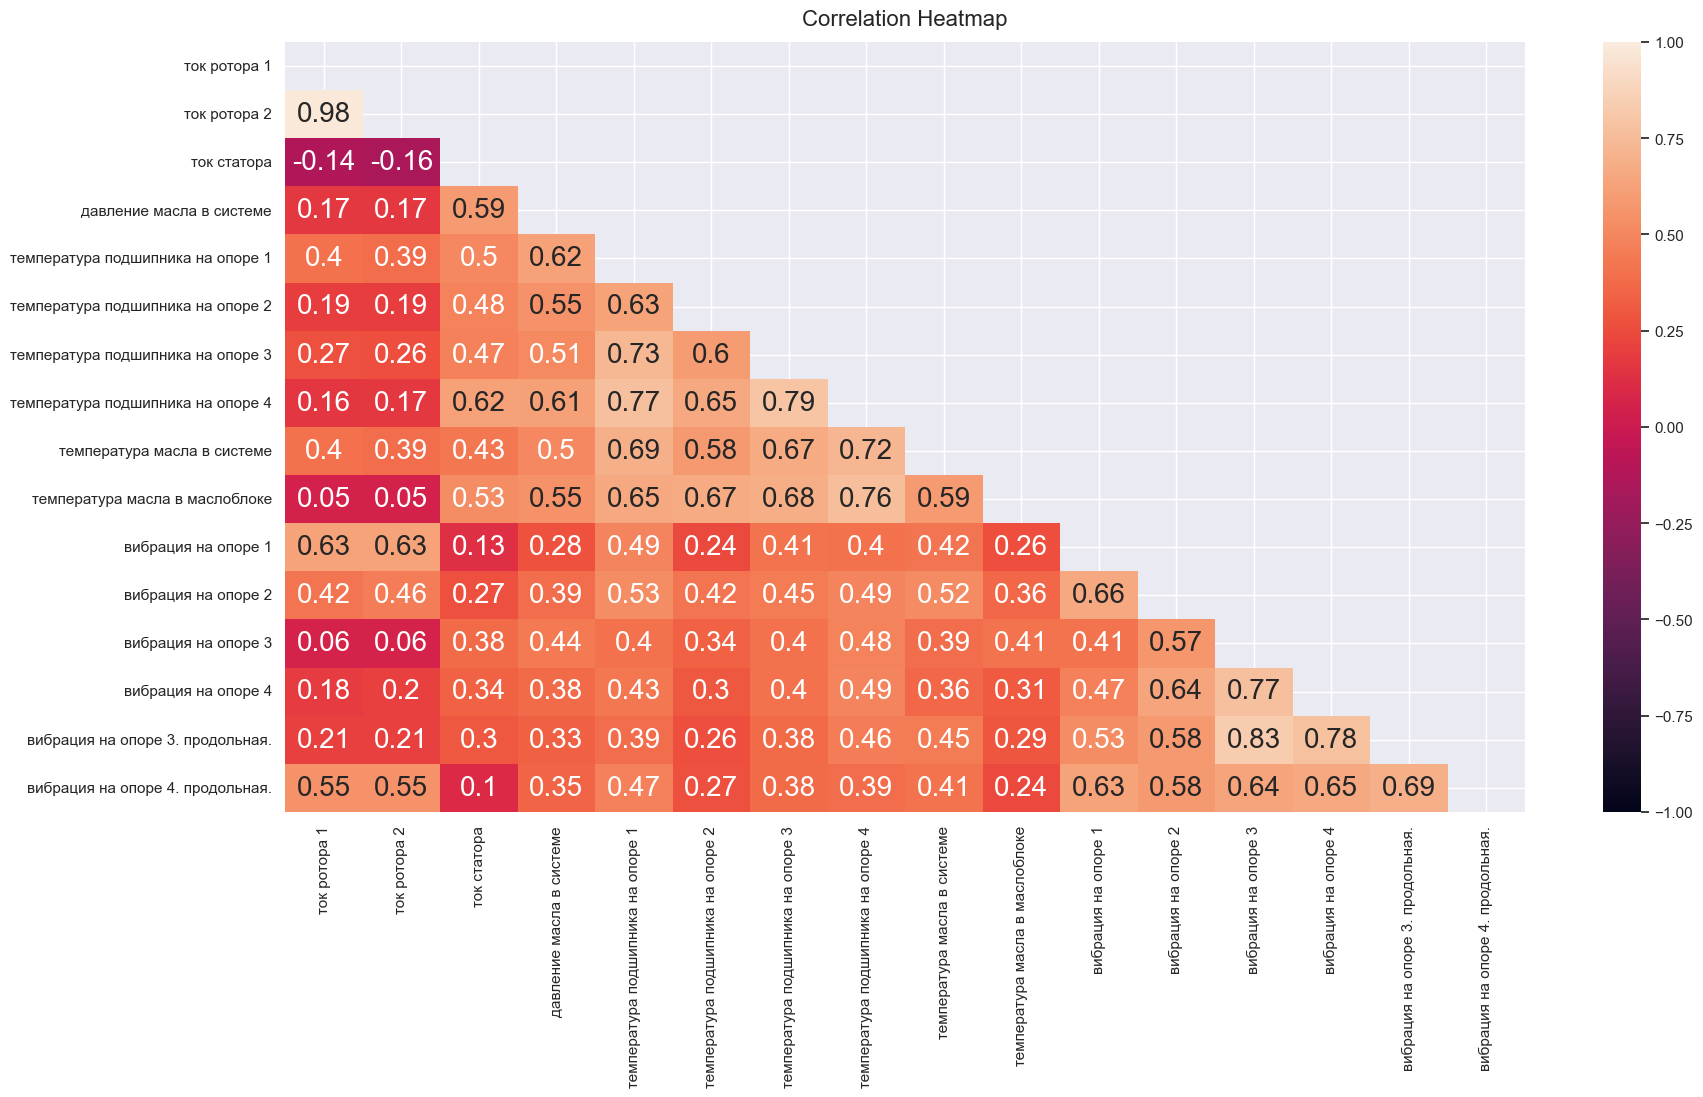

In [49]:
plot_corr_matrix(df_train_dict[EQUIP_NAMES[4]])

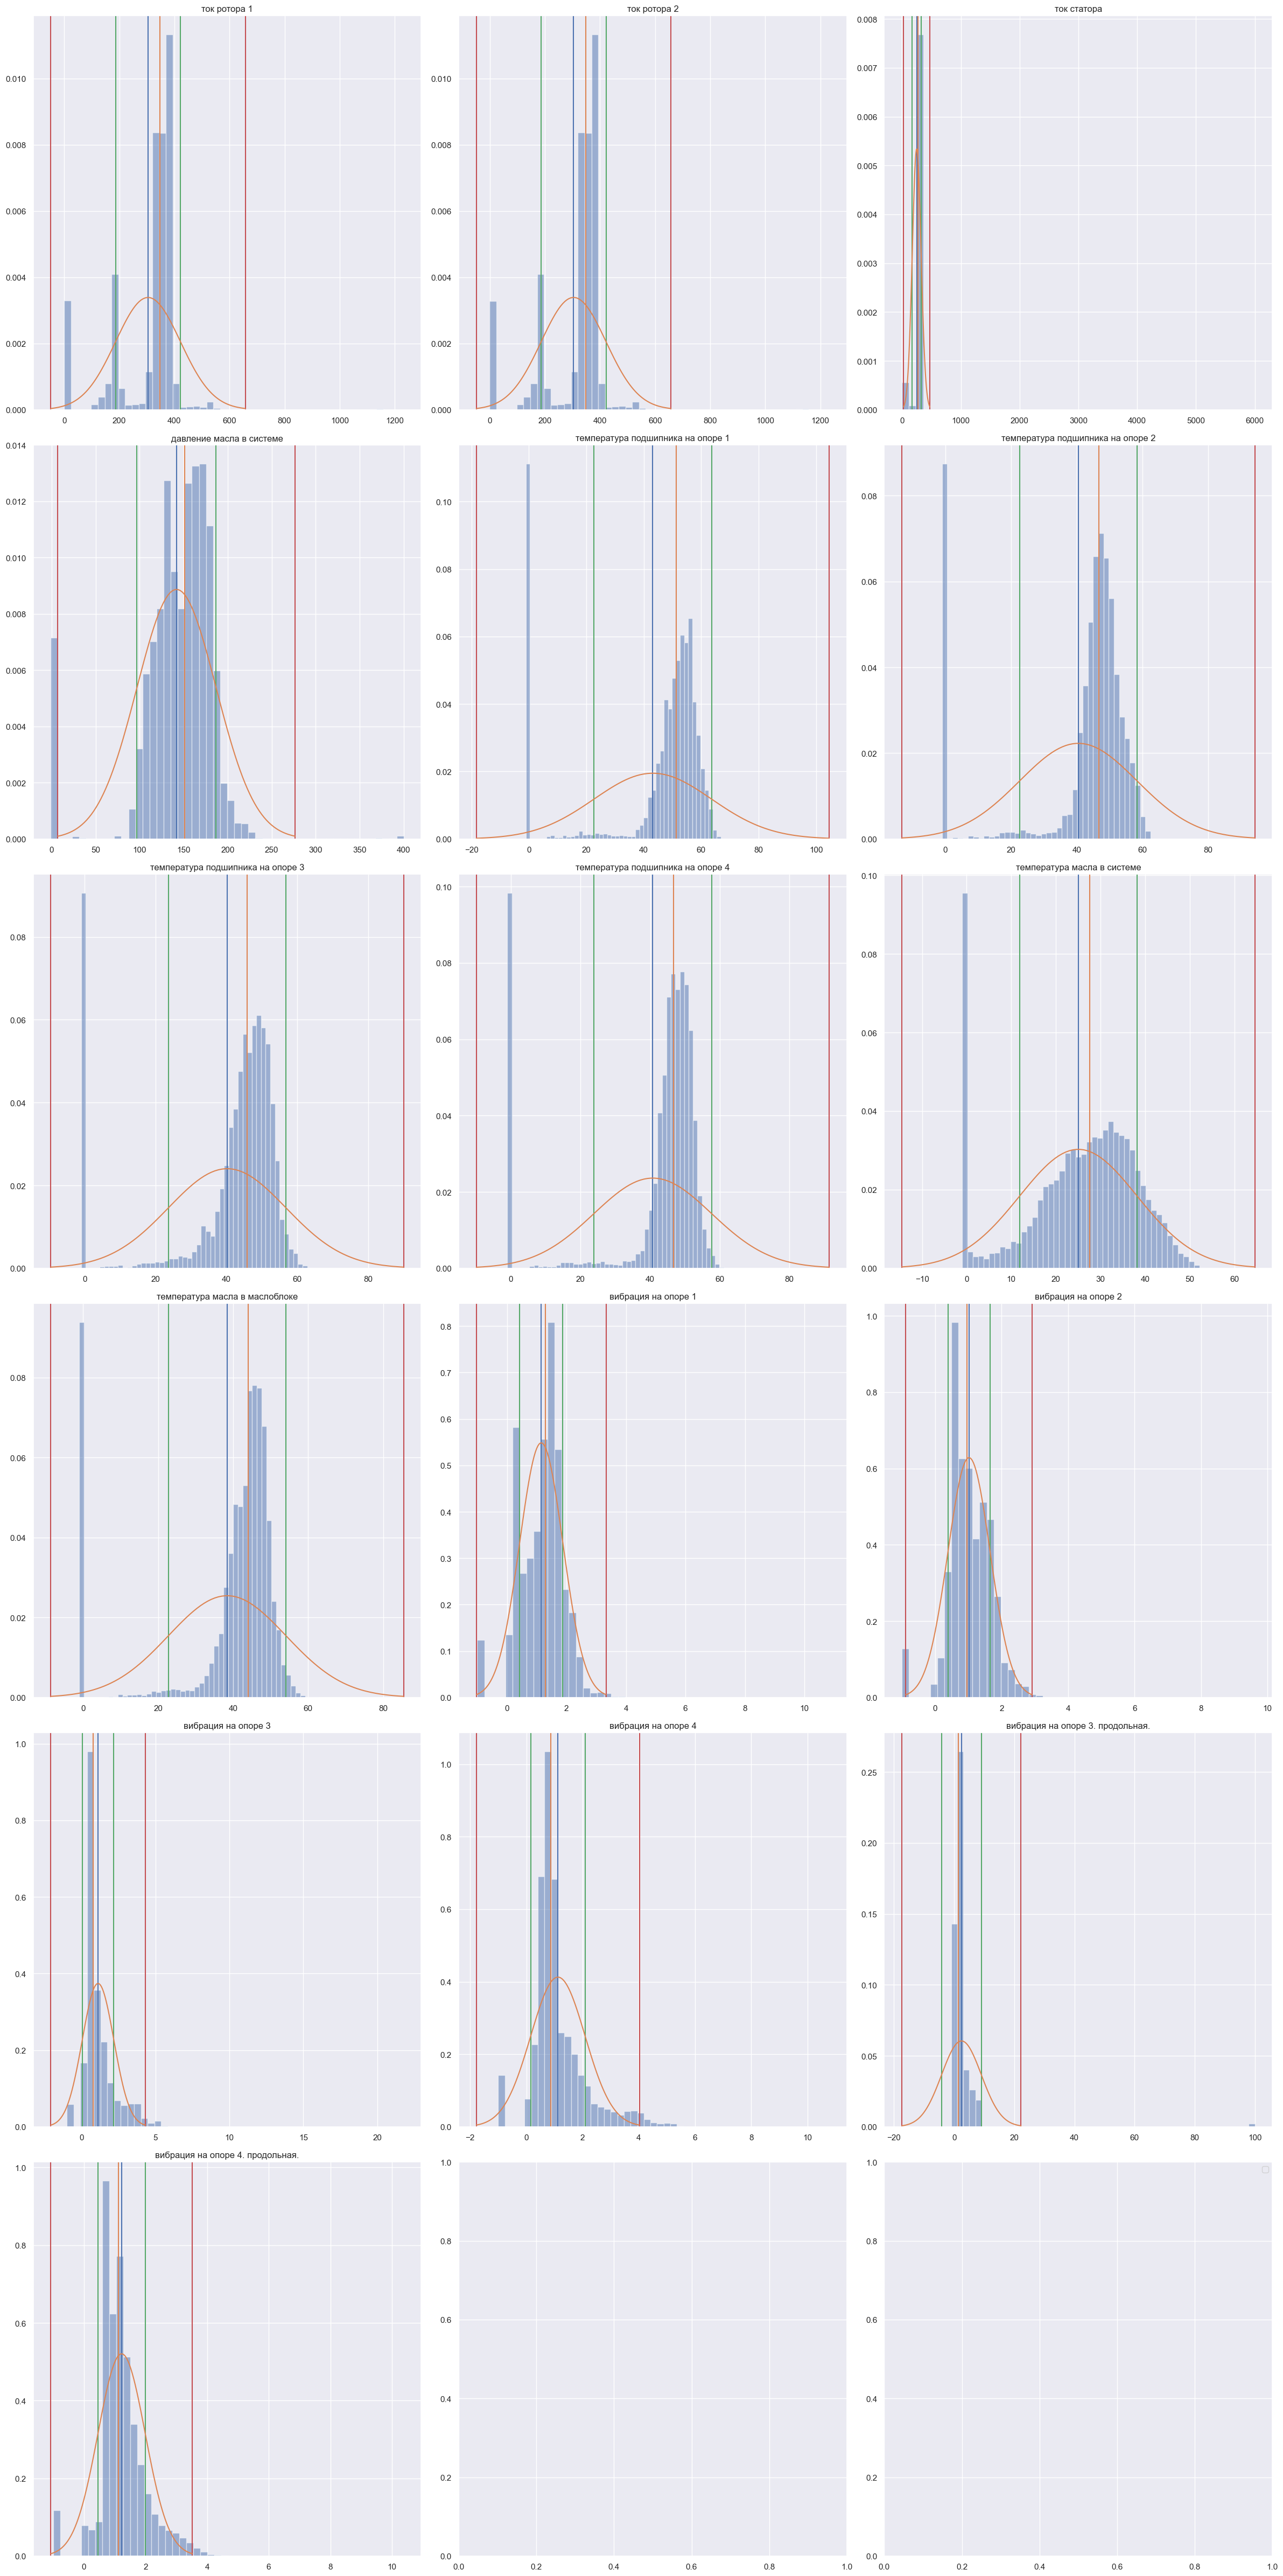

In [50]:
plot_grouped_hists(df_train_dict[visual_eqip], pal=PALETTE, nbins=50)

In [181]:
df_equip = df_meta[df_meta[EQUIP_NAME] == visual_eqip]
df_equip[(df_equip[START_END_FAILURE_DATES[0]] >= VISUAL_DATES[0]) & (df_equip[START_END_FAILURE_DATES[0]] <= VISUAL_DATES[1])]

,машина,имя_машины,тех_место,название_тех_места,вид_сообщения,описание,дата_начала_неисправности,дата_устранения_неисправности,текст_группы_кодов
119,AA2/003-006,эксгаустер 6,AA2/003-006-003-002,редуктор газ. задвижки,M3,обрыв резьбы на гайке редуктора подъема,2019-05-01 00:00:00,2019-05-22 00:00:00,NaN
121,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-003,задвижка,M1,упала задвижка на эксгаустере,2019-05-01 16:29:38,2019-05-01 19:18:04,1.0
122,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-003-002,редуктор газ. задвижки,M3,обрыв резьбы на гайке редуктора подъема,2019-05-01 18:15:29,2019-05-22 00:00:00,NaN
123,AA2/003-006,эксгаустер 6,AA2/003-006-003-003,задвижка,M1,упала задвижка на эксгаустере,2019-05-01 19:18:04,2019-05-01 19:18:04,1.0
130,CH-AGP-AG2/005-005,эксгаустер 6,CH-AGP-AG2/005-005-001-005-003,электродвигатель дспу-140-84-4,M3,износ 3 щеток,2019-05-11 11:09:25,2019-05-16 00:00:00,NaN


In [52]:
# df_equip[(df_equip[START_END_FAILURE_DATES[1]] >= '') & (df_equip[START_END_FAILURE_DATES[1]] <= '2019-05-01 16:29:38')]

# 4. Feature engineering

## 4.1. kNN

In [36]:
TIME_ANALYSE = 120
CUT_VALUE = len(df_train_dict[test_eqip]) - int(len(df_train_dict[test_eqip]) / TIME_ANALYSE) * TIME_ANALYSE
CLUSTER_COL = "кластер_knn"


MAX_ITER = 10
FIRST_CLUSTER = 6
CLUSTERS = 10
N_JOBS = 6
N_INIT = 3
METRICS_CLUSTER = 'softdtw' # 'euclidean', 'dtw', 'softdtw'

DT_IDXS = df_train_dict[test_eqip][CUT_VALUE::TIME_ANALYSE].index

In [37]:
# scale to have equal distance
scaler = StandardScaler()
df_test_scaled = scaler.fit_transform(df_train_dict[test_eqip])
    
# num of examples x length of timeseries x dimensions
df_test_scaled = df_test_scaled[CUT_VALUE:]
df_test_resized = np.resize(df_test_scaled, (int(df_test_scaled.shape[0] / TIME_ANALYSE), TIME_ANALYSE, df_test_scaled.shape[1]))

df_test_resized.shape

(12965, 120, 16)

In [560]:
plot_elbow(df_test_resized, seed=SEED, metric=METRICS_CLUSTER)

  0%|          | 0/10 [12:09<?, ?it/s]


KeyboardInterrupt: 

In [553]:
N_CLUSTERS = 9

In [39]:
all_equip = []

for key, val in df_train_dict.items():
    val = val.copy()
    val[EQUIP_NAME] = int(key[-1])
    all_equip.append(val[CUT_VALUE:])

df_all_equips = pd.concat(all_equip, axis=0)
print(df_all_equips.shape)

(9334800, 17)


In [40]:
# scale to have equal distance
scaler = StandardScaler()
df_test_scaled = scaler.fit_transform(df_all_equips.iloc[:,:-1])
    
# num of examples x length of timeseries x dimensions
# df_test_scaled = df_test_scaled[CUT_VALUE:]
df_test_resized = np.resize(df_test_scaled, (int(df_test_scaled.shape[0] / TIME_ANALYSE), TIME_ANALYSE, df_test_scaled.shape[1]))

print("Shape:", df_test_resized.shape)

Shape: (77790, 120, 16)


In [1221]:
ts_kmeans = TimeSeriesKMeans(n_clusters=N_CLUSTERS, n_init=N_INIT, metric=METRICS_CLUSTER, n_jobs=N_JOBS, max_iter=MAX_ITER, random_state=SEED)
ts_kmeans.fit(df_test_resized)

Shape: (77790, 120, 16)


TimeSeriesKMeans(max_iter=10, metric='softdtw', n_clusters=9, n_init=3,
                 n_jobs=6, random_state=42)

In [1223]:
df_test_clusters_knn = ts_kmeans.predict(df_test_resized)
# df_knn_values = pd.Series(df_test_clusters_knn, name=CLUSTER_COL, index=DT_IDXS)
df_test_clusters_knn.shape

In [70]:
DT_IDXS_ = df_all_equips[::TIME_ANALYSE].index
df_all_equips_proc = df_all_equips[::TIME_ANALYSE][[EQUIP_NAME]]
df_all_equips_proc[CLUSTER_COL] = df_test_clusters_knn
# df_all_equips_proc.to_csv(DATA_INTER_PATH / "all_knn_features.csv", index='dt')

NameError: name 'df_test_clusters_knn' is not defined

1173 min   
1523 min

In [1098]:
test_eqip = 'эксгаустер 9'
idx_ = 5

scaler = StandardScaler()
df_test_scaled = scaler.fit_transform(df_train_dict[test_eqip])
    
# num of examples x length of timeseries x dimensions
df_test_scaled = df_test_scaled[CUT_VALUE:]
df_test_resized = np.resize(df_test_scaled, (int(df_test_scaled.shape[0] / TIME_ANALYSE), TIME_ANALYSE, df_test_scaled.shape[1]))

KeyError: 'эксгаустер 10'

In [1083]:
df_test_clusters_knn = ts_kmeans.predict(df_test_resized)
# df_knn_values = pd.Series(np.concatenate(([df_test_clusters_knn[0]] * CUT_VALUE, np.repeat(df_test_clusters_knn, TIME_ANALYSE))), name=CLUSTER_COL)
df_knn_values = pd.Series(df_test_clusters_knn, name=CLUSTER_COL, index=DT_IDXS)

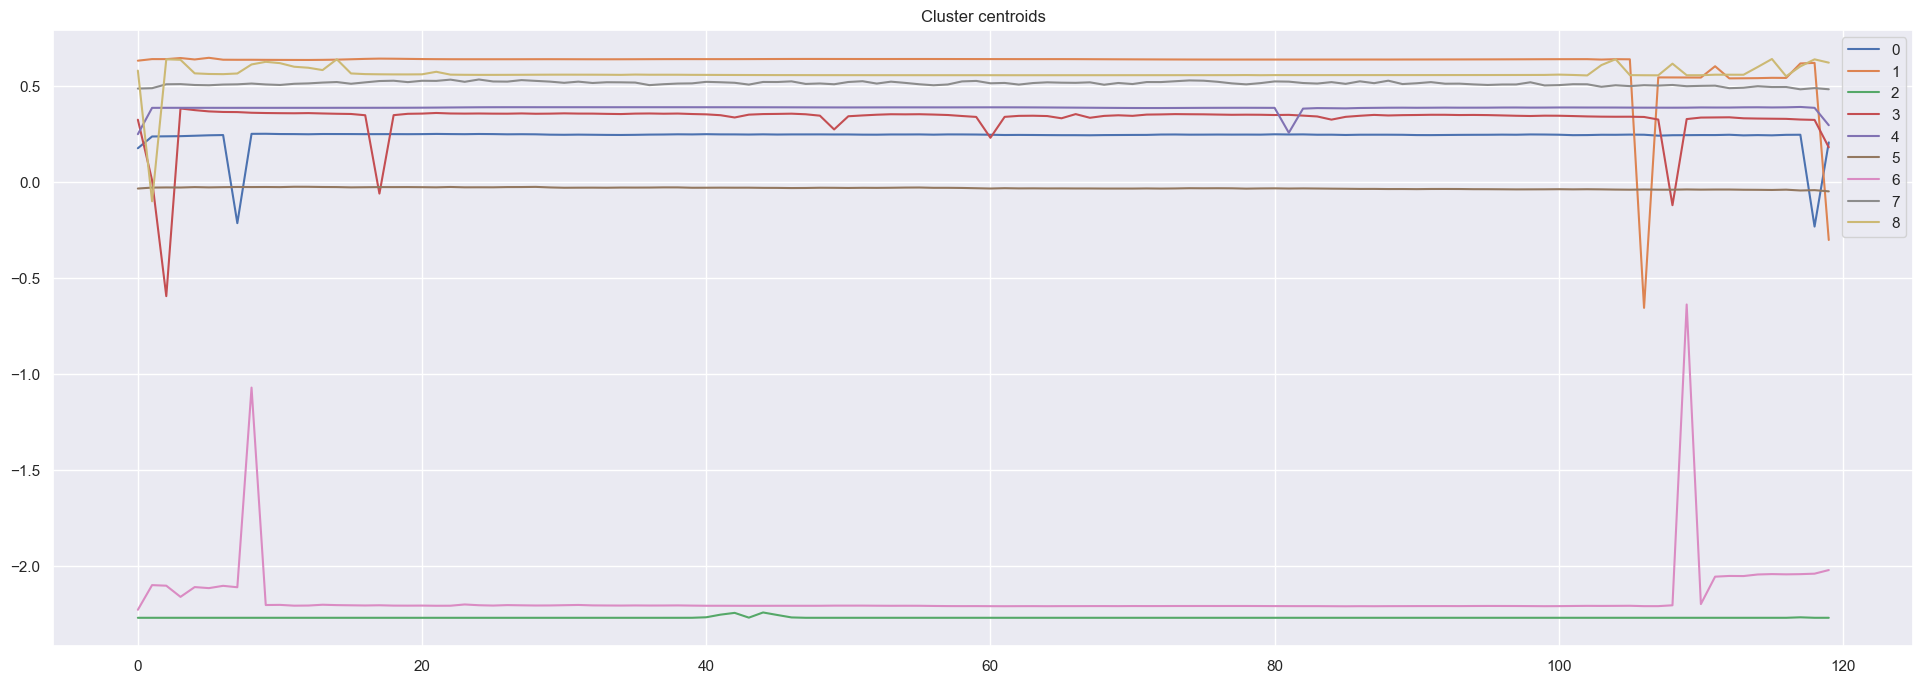

In [1225]:
for cluster_number in range(N_CLUSTERS):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [109]:
ts_kshape = KShape(n_clusters=N_CLUSTERS, n_init=N_INIT, max_iter=MAX_ITER, random_state=SEED)
ts_kshape.fit(df_test_resized)

KShape(max_iter=10, n_clusters=9, n_init=3, random_state=42)

In [112]:
# df_test_clusters_shape = ts_kshape.predict(df_test_resized)
# df_train_dict[test_eqip][CLUSTER_COL+"_kshape"] = np.concatenate(([df_test_clusters_shape[0]] * CUT_VALUE, np.repeat(df_test_clusters_shape, TIME_ANALYSE)))

# for cluster_number in range(N_CLUSTERS):
#     plt.plot(ts_kshape.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
# plt.title("Cluster centroids")
# plt.legend()
# plt.show()

Explained variance of 2 components 0.49989300238553513


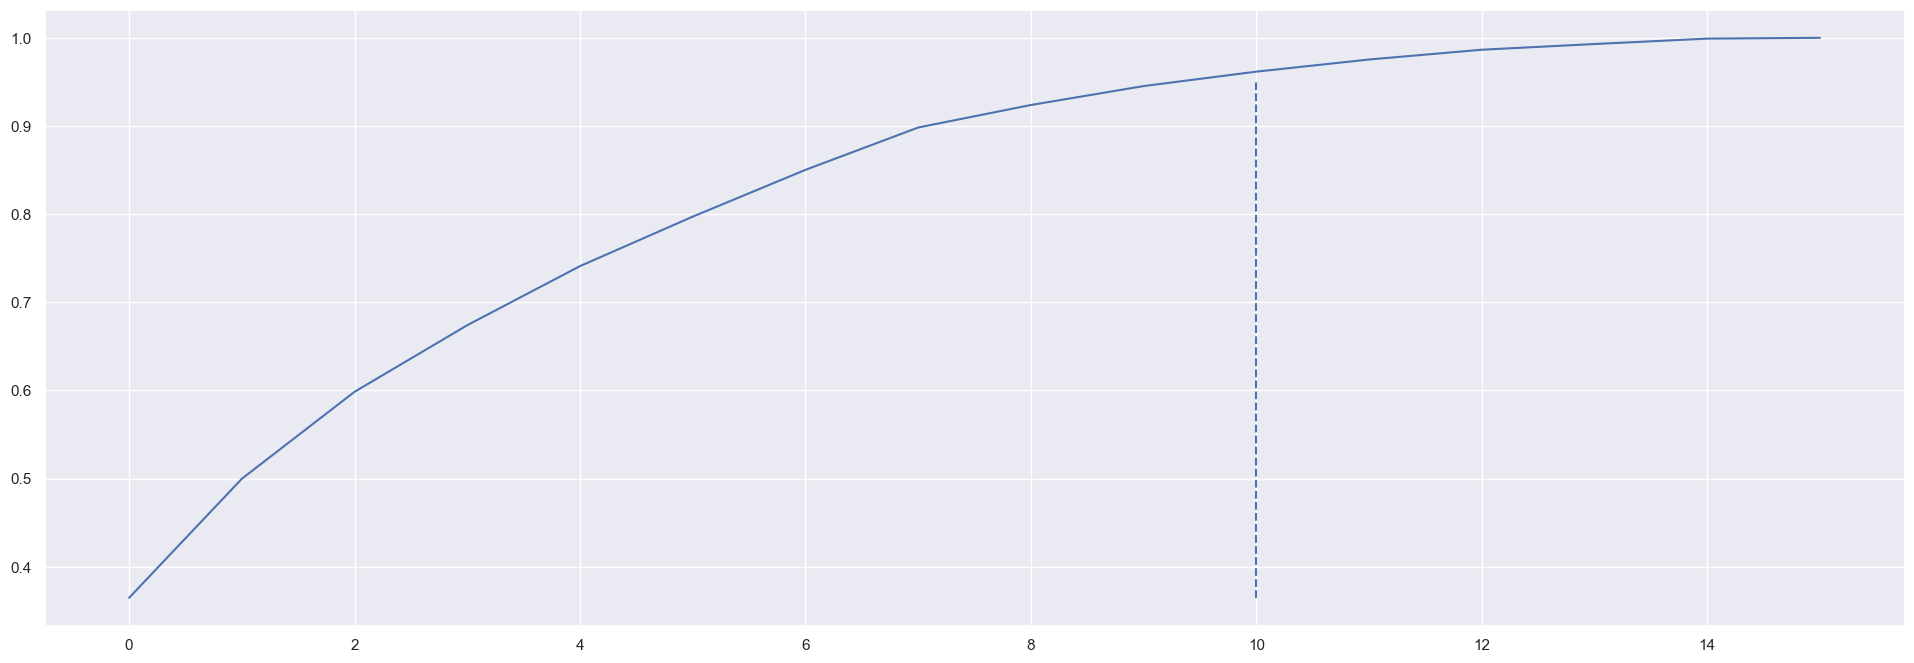

In [1247]:
pca_transformed = plot_and_get_pca(np.mean(df_test_resized, axis=1), SEED, is_plot=True)

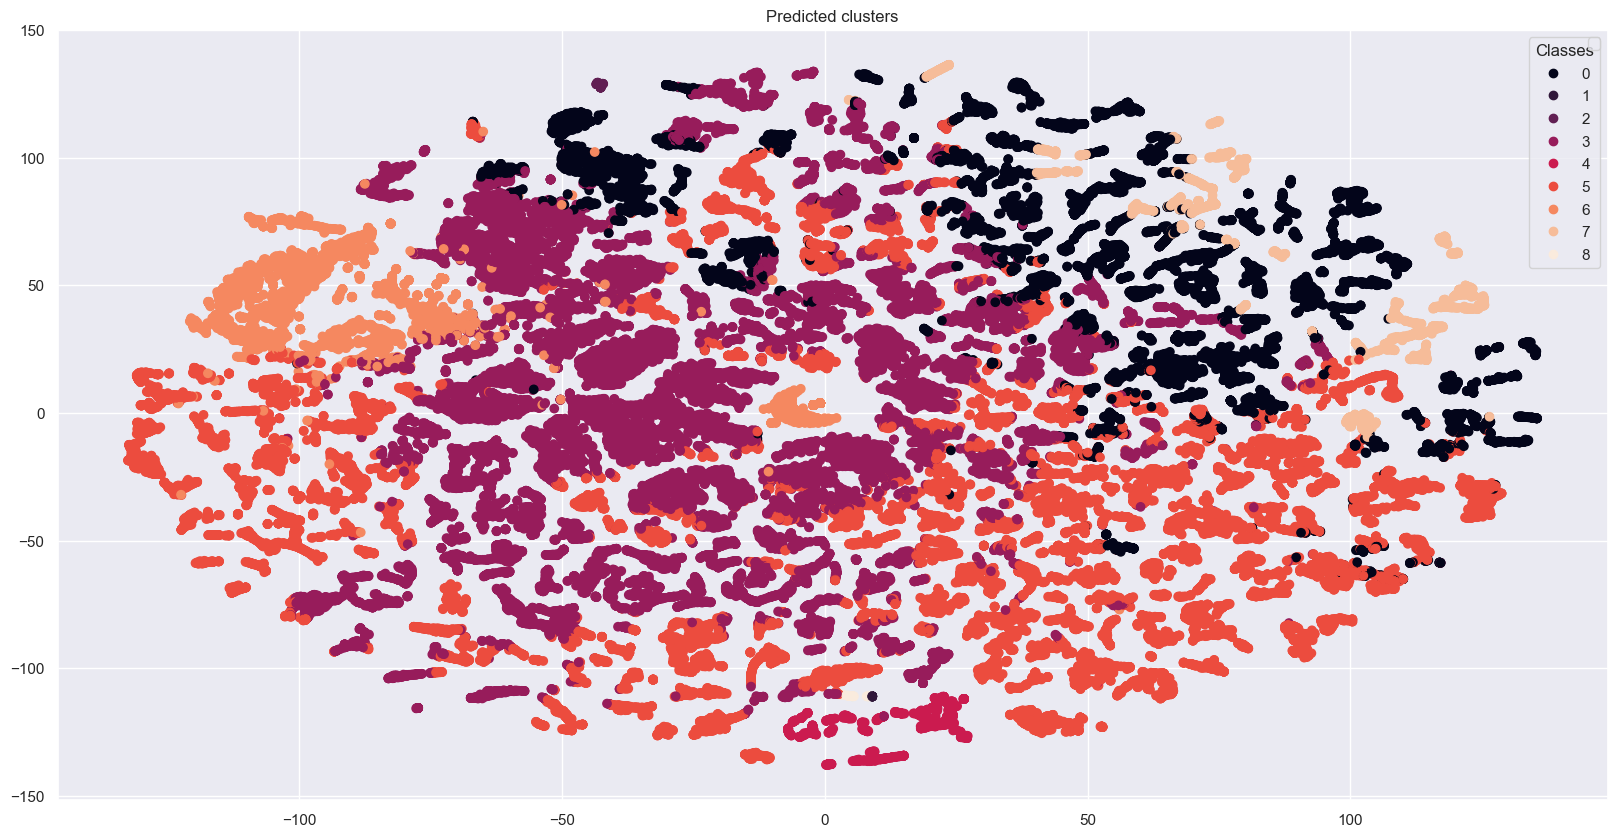

In [1248]:
tsne = TSNE(n_jobs=6, random_state=SEED)
tsne_transformed = tsne.fit_transform(pca_transformed)
plot_tsne(df_test_clusters_knn, tsne_transformed)

# tsne = TSNE(n_jobs=6, random_state=SEED)
# tsne_transformed = tsne.fit_transform(pca_transformed)
# plot_tsne(df_test_clusters_shape, tsne_transformed)

In [806]:
clusters = [CLUSTER_COL]
y_plots = [current_stator_cols, pressure_oil, bearing_temp + oil_temp, vibration_x + vibration_y, clusters]
y_axis_names = ['current_v', 'pressure_pa', 'temp_c', 'vib_µm', 'cluster_num']
y_axis_map_names = [f"y{i}" for i in range(1, len(y_plots)+1)]
y_places = [0, 0.05, 0.10, 0.95, 1.00]
plot_position = [0.10, 0.95]
savepath_plotly = PIC_EXPLORATORY_PATH / f"{visual_eqip}_knn_{VISUAL_DATES[0].replace(':', '-')}_{VISUAL_DATES[1].replace(':', '-')}.html"

df_to_visual = df_train_dict[visual_eqip].copy()
df_to_visual = df_to_visual[(df_to_visual.index >= VISUAL_DATES[0]) & (df_to_visual.index <= VISUAL_DATES[1])]
if smooth_window > 0:
    df_to_visual = df_to_visual.rolling(smooth_window).mean()

plot_time_series(df_to_visual, y_axis_map_names, y_plots, y_axis_names, y_places, plot_position, titles_plotly, savepath_plotly, colors)

KeyError: 'кластер'

## 4.2. FFT and PSD

In [88]:
t_n = 1                      # длина нашего сигнала в секундах
N = TIME_ANALYSE             # длина сигнала
T = t_n / N                  # период сигнала (шаг между точками?)
f_s = 1 / T                  # частота Hz
SAMPLE_RATE = 1 / f_s

DENOMINATOR = 10
PEAKS_PERCENTILE = 5
NO_PEAKS = 5

if GROUP_FREQ == '1Min':
    VALS_IN_GROUP_FREQ = int(60 / FREQ)
else:
    raise NameError

In [89]:
all_equip_vib = []

for key, val in df_train_vib_dict.items():
    val = val.copy()
    val[EQUIP_NAME] = int(key[-1])
    all_equip_vib.append(val[CUT_VALUE * VALS_IN_GROUP_FREQ:])

df_all_equips_vib = pd.concat(all_equip_vib, axis=0)
print(df_all_equips_vib.shape)

(56008800, 7)


In [91]:
df_test_vib_scaled = df_train_vib_dict[test_eqip][CUT_VALUE * VALS_IN_GROUP_FREQ:]
df_test_vib_resized = np.resize(df_test_vib_scaled, (int(df_test_vib_scaled.shape[0] / (TIME_ANALYSE * VALS_IN_GROUP_FREQ)), TIME_ANALYSE * VALS_IN_GROUP_FREQ, df_test_vib_scaled.shape[1]))

df_test_vib_resized.shape

(12965, 720, 6)

In [92]:
df_test_vib_scaled = df_all_equips_vib.iloc[:, :-1]
df_test_vib_resized = np.resize(df_test_vib_scaled, (int(df_test_vib_scaled.shape[0] / (TIME_ANALYSE * VALS_IN_GROUP_FREQ)), TIME_ANALYSE * VALS_IN_GROUP_FREQ, df_test_vib_scaled.shape[1]))

df_test_vib_resized.shape

(77790, 720, 6)

In [93]:
_, fft_values = get_fft_values(df_test_vib_resized, T, N, f_s)
fft_values.shape

(77790, 60, 6)

In [94]:
_, psd_values = get_psd_values(df_test_vib_resized, T, N, f_s)
psd_values.shape

(77790, 129, 6)

In [95]:
fft_peaks_values = get_signals_peaks(fft_values, DENOMINATOR, PEAKS_PERCENTILE, NO_PEAKS)
psd_values_values = get_signals_peaks(psd_values, DENOMINATOR, PEAKS_PERCENTILE, NO_PEAKS)
print(fft_peaks_values.shape, psd_values_values.shape)

(77790, 5, 6) (77790, 5, 6)


In [96]:
print(fft_peaks_values.shape, psd_values_values.shape)

(77790, 5, 6) (77790, 5, 6)


In [109]:
df_fft_cols = ['fft_' + colname + f'_{i}' for i in range(1, NO_PEAKS+1) for colname in df_all_equips_vib.columns[:-1]]
df_psd_cols = ['psd_' + colname + f'_{i}' for i in range(1, NO_PEAKS+1) for colname in df_all_equips_vib.columns[:-1]]

df_fft_vals = pd.DataFrame(fft_peaks_values.reshape(fft_peaks_values.shape[0], -1), columns=df_fft_cols, index=DT_IDXS_)
# df_fft_vals[CLUSTER_COL] = df_all_equips_proc[CLUSTER_COL]
df_psd_vals = pd.DataFrame(fft_peaks_values.reshape(fft_peaks_values.shape[0], -1), columns=df_psd_cols, index=DT_IDXS_)
# df_psd_vals[CLUSTER_COL] = df_all_equips_proc[CLUSTER_COL]
df_fft_psd_vals = pd.concat([df_all_equips_proc[EQUIP_NAME], df_fft_vals, df_psd_vals,], axis=1)


print(df_fft_psd_vals.shape)

(77790, 61)


In [110]:
# df_fft_psd_vals.to_csv(DATA_INTER_PATH / "all_ftt_psd_features.csv", index="ts")

## 4.3. Tsfel features

In [41]:
from joblib import Parallel, delayed

In [42]:
TSFEL_CFG_FILE = tsfel.get_features_by_domain() # tsfel.get_features_by_domain('temporal')
SAMPLING_FREQ = TIME_ANALYSE
TSFEL_TRESH = 0.85

In [43]:
df_test_resized.shape

(77790, 120, 16)

In [44]:
def get_tsfel_features(df_test_resized: np.ndarray) -> np.ndarray:
    tsfel_feature = np.empty((df_test_resized.shape[0], 194))
    for sample_idx in tqdm(range(tsfel_feature.shape[0])):
        tsfel_feature[sample_idx, :] = tsfel.time_series_features_extractor(TSFEL_CFG_FILE, df_test_resized[sample_idx, :], fs=SAMPLING_FREQ, verbose=False)
    return tsfel_feature
        
def get_lists_joblib(df_test_resized: np.ndarray, n_jobs=16):
    tsfel_lists = Parallel(n_jobs=n_jobs, verbose=True)(delayed(get_tsfel_features)(df_test_resized[:,:,idx]) for idx in range(df_test_resized.shape[2]))
    return tsfel_lists

In [45]:
tsfel_equips = get_lists_joblib(df_test_resized, n_jobs=16)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed: 104.1min remaining: 728.6min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed: 108.2min finished


In [61]:
# tsfel_equips = []

# tsfel_features = np.empty((df_test_resized.shape[0], 194, df_test_resized.shape[2]))

# for feature_idx in tqdm(range(tsfel_features.shape[2]), leave=False):
#     for sample_idx in range(tsfel_features.shape[0]):
#         tsfel_features[sample_idx, :, feature_idx] = tsfel.time_series_features_extractor(TSFEL_CFG_FILE, df_test_resized[sample_idx, :, feature_idx], fs=SAMPLING_FREQ, verbose=False)

# print(tsfel_features.shape)
# tsfel_equips.append(tsfel_features)

KeyboardInterrupt: 

In [46]:
def select_var_threshold(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    return df[df.columns[selector.get_support(indices=True)]]

In [58]:
assert tsfel_equips_concat.shape[0] == df_test_resized.shape[0] * df_test_resized.shape[2]

In [67]:
tsfel_equips_concat_ = copy.deepcopy(tsfel_equips_concat)

In [61]:
tsfel_equips_concat = np.concatenate([feature[..., np.newaxis] for feature in tsfel_equips], axis=2)
tsfel_equips_concat.shape

In [84]:
equip_names = []

tsfel_equips_features = [df_all_equips_proc[EQUIP_NAME]]
tsfel_columns = tsfel.time_series_features_extractor(TSFEL_CFG_FILE, df_train_dict[test_eqip].iloc[:SAMPLING_FREQ,0], fs=SAMPLING_FREQ, verbose=False).columns


for idx in range(tsfel_equips_concat.shape[2]):
    # Highly correlated features are removed
    colname = df_train_dict[test_eqip].columns[idx] 
    columns_ = colname + tsfel_columns.str[1:]
    features_ = pd.DataFrame(tsfel_equips_concat[:,:,idx], columns=columns_, index=DT_IDXS_)
    corr_features = tsfel.correlated_features(features_, threshold=TSFEL_TRESH)
    features_.drop(corr_features, axis=1, inplace=True)

    # Remove low variance features
    features_ = select_var_threshold(features_)

    print(f"Num of samples x features in {colname}:", features_.shape)
    tsfel_equips_features.append(features_)
    
df_tsfel = pd.concat(tsfel_equips_features, axis=1)
df_tsfel.shape
# print(df_tsfel.shape)
# equip_names.append(df_tsfel)

Num of samples x features in ток ротора 1: (77790, 34)
Num of samples x features in ток ротора 2: (77790, 34)
Num of samples x features in ток статора: (77790, 25)
Num of samples x features in давление масла в системе: (77790, 35)
Num of samples x features in температура подшипника на опоре 1: (77790, 34)
Num of samples x features in температура подшипника на опоре 2: (77790, 34)
Num of samples x features in температура подшипника на опоре 3: (77790, 35)
Num of samples x features in температура подшипника на опоре 4: (77790, 36)
Num of samples x features in температура масла в системе: (77790, 34)
Num of samples x features in температура масла в маслоблоке: (77790, 35)
Num of samples x features in вибрация на опоре 1: (77790, 33)
Num of samples x features in вибрация на опоре 2: (77790, 36)
Num of samples x features in вибрация на опоре 3: (77790, 34)
Num of samples x features in вибрация на опоре 4: (77790, 34)
Num of samples x features in вибрация на опоре 3. продольная.: (77790, 31)

(77790, 540)

In [87]:
# df_tsfel.to_csv(DATA_INTER_PATH / "all_tsfel_features.csv", index="ts")

## 4.4. Time-based features

In [114]:
df_month = pd.Series(df_all_equips_proc.index.month, name="month", index=df_all_equips_proc.index) 
df_day = pd.Series(((df_all_equips_proc.index.hour > 6) & (df_all_equips_proc.index.hour <= 18)), name="is_day", index=df_all_equips_proc.index)
df_time_values = pd.concat([df_month, df_day], axis=1)

df_time_values.shape

(77790, 2)

In [115]:
# df_time_values.to_csv(DATA_INTER_PATH / "all_time_based_features.csv", index="ts")

## 4.5. State-based features

In [117]:
all_equip_states = []

for key, val in df_train_state_dict.items():
    val = val.copy()
    val[EQUIP_NAME] = int(key[-1])
    all_equip_states.append(val[CUT_VALUE:])

df_all_equips_states = pd.concat(all_equip_states, axis=0)
print(df_all_equips_states.shape)

(9334800, 17)


In [381]:
train_state = []

for equip_name in EQUIP_NAMES:
    df_all_equip_state = df_all_equips_states[df_all_equips_states[EQUIP_NAME] == int(equip_name[-1])]
    train_state.append(df_all_equip_state.iloc[:, :-1].groupby(pd.Grouper(freq=str(TIME_ANALYSE) + "min")).aggregate(GROUP_FUNC_Y))


df_train_state = pd.concat(train_state, axis=0)
df_train_state = df_train_state.astype(np.int8)
df_train_state.columns += "_state"
df_train_state[EQUIP_NAME] = df_all_equips_proc[EQUIP_NAME]

print(df_train_state.shape)

(77790, 17)


In [382]:
# df_train_state.to_csv(DATA_INTER_PATH / "all_states_features.csv", index="ts")

## 4.6. Gather all features

In [1096]:
# kNN
print("kNN feature", df_knn_values.shape)

# ftt, psd
print("FFT and PSD features", df_fft_vals.shape, df_psd_vals.shape)

# tsfel
# print("TSFEL features", df_tsfel.shape)

# time features
print("Time-based features", df_time_values.shape)

# state features
print("State features", df_train_state.shape)

# all features
df_preproc_features = pd.concat([df_knn_values,
                                 df_fft_vals,
                                #  df_tsfel,
                                 df_time_values,
                                 df_train_state], axis=1)
print(df_preproc_features.shape)

kNN feature (12965,)
FFT and PSD features (12965, 30) (12965, 30)
Time-based features (12965, 2)
State features (12965, 16)
(12965, 49)


In [1097]:
df_preproc_features.to_csv(DATA_PROC_PATH / (test_eqip.replace(' ', '_') + '_' + datetime.today().strftime('%Y-%m-%d') + SAVE_EXT))
# df_meta.to_csv(DATA_PROC_PATH / (METAINFO_SAVE + SAVE_EXT))

In [1103]:
# df_preproc_features = pd.read_csv(DATA_PROC_PATH / "эксгаустер_5_2023-10-16.csv", index_col=DATETIME_COL)

In [143]:
df_meta

,машина,имя_машины,тех_место,название_тех_места,вид_сообщения,описание,дата_начала_неисправности,дата_устранения_неисправности,текст_группы_кодов,длительность
0,AA2/006-006,эксгаустер 9,AA2/006-006-002-008,запорная арматура,M3,неисправен двигатель,2019-01-21 00:00:00,2019-02-25 00:00:00,NaN,35 days 00:00:00
1,CH-AGP-AG2/011-005,эксгаустер 9,CH-AGP-AG2/011-005-002,маслостанция жидкой смазки,M3,неисправен двигатель,2019-01-21 12:26:08,2019-02-25 00:00:00,NaN,34 days 11:33:52
2,AA2/002-006,эксгаустер 5,AA2/002-006-002-004,маслоохладитель м-05-1,M3,менять прокладку на подачу воды в охлади,2019-01-21 15:35:26,2019-01-23 11:00:00,NaN,1 days 19:24:34
3,CH-AGP-AG2/003-005,эксгаустер 5,CH-AGP-AG2/003-005-002-004,маслоохладитель м-05-1,M3,менять прокладку на подачу воды в охлади,2019-01-21 16:33:00,2019-01-22 00:00:00,NaN,0 days 07:27:00
4,CH-AGP-AG2/003-005,эксгаустер 5,CH-AGP-AG2/003-005-002-004,маслоохладитель м-05-1,M3,менять прокладку на подачу воды в охлади,2019-01-21 16:36:01,2019-06-04 15:35:26,NaN,133 days 22:59:25
...,...,...,...,...,...,...,...,...,...,...
976,AA2/005-006,эксгаустер 8,AA2/005-006-001-005-001,электрооборудования,M3,Концевой выключатель на открытие г.задв.,2021-12-28 09:20:00,2021-12-30 00:00:00,NaN,1 days 14:40:00
977,AA2/005-006,эксгаустер 8,AA2/005-006-003-002,редуктор газ. задвижки,M3,Смазка редуктора.,2021-12-28 09:23:00,2022-03-10 13:25:52,NaN,72 days 04:02:52.102564103
978,AA2/003-006,эксгаустер 6,AA2/003-006-001-001,корпус,M3,Прососы,2021-12-28 12:23:00,2022-02-16 19:49:46,NaN,50 days 07:26:45.789473684
979,AA2/001-006,эксгаустер 4,AA2/001-006-001-006,улита,M3,Прососы,2021-12-28 12:39:00,2022-03-05 09:10:17,NaN,66 days 20:31:17


In [183]:
# df_meta[(df_meta[EQUIP_NAME] == test_eqip) & (df_meta[FAILURE_TYPE_COL] == FAILURES_CODES["malfunction"])]
df_target = pd.DataFrame(0, columns=df_meta[FAILURE_PART_COL].unique(), index=np.tile(DT_IDXS, len(EQUIP_NAMES)))
df_target[EQUIP_NAME] = np.repeat([int(name[-1]) for name in EQUIP_NAMES], len(DT_IDXS))

for equip_name in EQUIP_NAMES:
    df_meta_equip = df_meta[df_meta[EQUIP_NAME] == equip_name]
    equip_filter = df_target[EQUIP_NAME] == int(equip_name[-1])
    equip_filter_meta = df_meta_equip[EQUIP_NAME] == equip_name
    for idx, df_row in df_meta_equip[(df_meta_equip[FAILURE_TYPE_COL] == FAILURES_CODES["malfunction"]) & (equip_filter_meta)].iterrows():
        failure_part_col_ = df_row[FAILURE_PART_COL]
        date_filter_ = ((df_target.index >= df_row[START_END_FAILURE_DATES[0]]) 
                        & (df_target.index <= df_row[START_END_FAILURE_DATES[1]]))
        df_target.loc[date_filter_ & equip_filter, failure_part_col_] += 1
    
df_target.where(df_target.iloc[:,:-1] <= 1, 1, inplace=True)

## 5. Prepare target

In [186]:
# 'сапфир 22 мдд разрежение в коллекторе' - датчик измерения давления разрежения
#  'тр-р тм-6300-10/6', 'тр-р тм-4000-10/6' - трансформатор
# 'метран-100 датчики давления'
FAILURE_TRANSFORMER = {'эксгаустер 4': 'тр-р тм-4000-10/6',
                       'эксгаустер 5': 'тр-р тм-4000-10/6',
                       'эксгаустер 6': 'тр-р тм-4000-10/6',
                       'эксгаустер 7': 'тр-р тм-4000-10/6',
                       'эксгаустер 8': 'тр-р тм-6300-10/6',
                       'эксгаустер 9': 'тр-р тм-6300-10/6',
                       }

FAILURE_GROUPS = {'oil_equip': ['маслостанция жидкой смазки', 'маслоохладитель  м-05-1', 'маслонасос рабочий', 'тсмт-101-010-50м-80 термопреобр.масло', 'гсм', 'маслопроводы', 'маслобак', 'масляный фильтр', 'двигатель пускового маслонасоса',
                                'маслонасос шестеренчатый (рез.)', 'маслонасос шестеренчатый (пуск.)',],
                  'electric_equip_common': ['электродвигатель дспу-140-84-4', 'электроаппаратура',
                                            'кл1 тр до эд', 'кл2 тр до эд',
                                            'электрооборудования',
                                            'тиристорный возбудитель спвд-м10-400-5', 'тирист. возбудитель вт-рэм-400 ву1', 'тиристорный возбудитель тв-400 ву1', 'тирист. возбудитель вт-рэм-400 ву2'], 
                  'rotating': ['ротор'],
                  'valves': ['запорная арматура', 'редуктор газ. задвижки', 'задвижка', 'эл/двигатель газ. задвижки', 'зап. и рег. арматура', 'газовая задвижка а/м'],
                  'bearings_mech': ['подшипник опорный',
                                    'подшипник опорный №1', 'подшипник опорный №2',
                                    'вк 310с вибропреобразователь т.1', 'вк 310с вибропреобразователь т.2', 'вк 310с вибропреобразователь т.3', 'вк 310с вибропреобразователь т.4',
                                    'подшипник опорно-упорный', ],
                  'bearing_temp': ['тсмт-101-010-50м-400 термопр.подш.т.1', 'тсмт-101-010-50м-400 термопр.подш.т.2', 'тсмт-101-010-50м-200 термопр.подш.т.3', 'тсмт-101-010-50м-200 термопр.подш.т.4'],
                  'static_equp': ['корпус', 'улита', 'кожух муфты', ],
                  'process': ['сапфир 22 мдд разрежение в коллекторе', 'сапфир 22 мдд перепад давл. на циклоне', 'метран-100 датчики давления', 'эксгаустер а/м', ]}

failure_name_group = {}

for key, vals in FAILURE_GROUPS.items():
    for val in vals:
        failure_name_group[val] = key 

In [199]:
df_target_renamed = df_target.rename(failure_name_group, axis=1)
df_target_unique_cols = list(FAILURE_GROUPS.keys()) + list(set(FAILURE_TRANSFORMER.values())) + [EQUIP_NAME]
target_grouped = {}


for col in df_target_unique_cols:
    if df_target_renamed[[col]].shape[1] > 1:
        target_grouped[col] = df_target_renamed[col].sum(axis=1)
    else: 
        target_grouped[col] = df_target_renamed[col]
        
df_target_grouped = pd.DataFrame(target_grouped)
df_target_grouped.where(df_target_grouped.iloc[:, :-1] <= 1, 1, inplace=True)

In [200]:
display(df_target_grouped.describe())
print(df_target_grouped.sum())

,oil_equip,electric_equip_common,rotating,valves,bearings_mech,bearing_temp,static_equp,process,тр-р тм-6300-10/6,тр-р тм-4000-10/6,имя_машины
count,77790.000000,77790.0000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000
mean,0.617046,0.5828,0.354724,0.627510,0.465613,0.000064,0.675087,0.000090,0.109063,0.010593,6.500000
std,0.486110,0.4931,0.478433,0.483471,0.498819,0.008017,0.468345,0.009486,0.311720,0.102375,1.707836
min,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,1.000000,1.0000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.500000
75%,1.000000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8.000000
max,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


oil_equip                 48000
electric_equip_common     45336
rotating                  27594
valves                    48814
bearings_mech             36220
bearing_temp                  5
static_equp               52515
process                       7
тр-р тм-6300-10/6          8484
тр-р тм-4000-10/6           824
имя_машины               505635
dtype: int64


In [212]:
train_init = []

for equip_name in EQUIP_NAMES:
    train_init.append(df_all_equips[df_all_equips[EQUIP_NAME] == int(equip_name[-1])].groupby(pd.Grouper(freq=str(TIME_ANALYSE) + "min")).aggregate(GROUP_FUNC_Y))
    
df_train_init = pd.concat(train_init, axis=0)
df_train_init = df_train_init.astype(FLOAT_TYPE)
df_train_init[EQUIP_NAME] = df_train_init[EQUIP_NAME].astype(INT_TYPE)
print(df_train_init.shape)
df_describe_info(df_train_init)

(77790, 17)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77790 entries, 2019-01-16 14:00:00 to 2021-12-31 22:00:00
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ток ротора 1                       77790 non-null  float32
 1   ток ротора 2                       77790 non-null  float32
 2   ток статора                        77790 non-null  float32
 3   давление масла в системе           77790 non-null  float32
 4   температура подшипника на опоре 1  77790 non-null  float32
 5   температура подшипника на опоре 2  77790 non-null  float32
 6   температура подшипника на опоре 3  77790 non-null  float32
 7   температура подшипника на опоре 4  77790 non-null  float32
 8   температура масла в системе        77790 non-null  float32
 9   температура масла в маслоблоке     77790 non-null  float32
 10  вибрация на опоре 1                77790 non-null  float32
 11  вибраци

None

,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.,имя_машины
count,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000,77790.000000
mean,292.027374,291.444916,302.767944,129.570862,44.920574,43.987541,41.401344,45.670757,31.032759,38.757172,1.719103,1.005354,1.094155,1.373559,1.983795,1.413039,6.500000
std,121.231934,121.727089,619.209412,43.566380,14.151276,13.350728,11.771713,12.707120,12.124207,29.161345,1.700179,0.736020,1.071426,1.285467,3.064321,1.140289,1.707836
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.000000
0.2%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.000000
1%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.000000
5%,1.423823,1.279389,0.175000,0.000000,-1.000000,-1.000000,9.801974,14.870000,5.275000,11.035602,0.104489,0.112569,0.117408,0.133954,0.128090,0.126608,4.000000
50%,343.049133,342.855133,261.492493,133.296837,48.485525,46.645000,43.857986,47.862915,33.259998,40.769152,1.320068,0.927750,0.770000,1.057479,1.436024,1.195833,6.500000
95%,392.884149,392.879507,287.837509,185.957951,58.497597,57.863681,53.135002,58.827130,46.847500,49.895000,5.018426,2.171297,3.287450,3.889318,5.408832,3.356245,9.000000
99%,401.706895,401.650850,6000.000000,224.547012,61.511891,60.902686,56.593006,62.275993,50.066195,53.270000,8.375672,3.468015,4.947040,6.024049,7.737428,5.404005,9.000000


NaNs portion: 0.000


# 6. Baseline

In [542]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

from sklearn.utils._bunch import Bunch as sklearn_bunch
from matplotlib.figure import Figure as mpl_figure

from collections import Counter

In [363]:
def calc_metric(y_true: np.ndarray, predict: np.ndarray, colnames: list[str]) -> dict[str, float]:
    """_summary_

    Args:
        y_train (np.ndarray): _description_
        predict (np.ndarray): _description_

    Returns:
        list[float]: _description_
    """
    matrixes_res = multilabel_confusion_matrix(y_true, predict)
    metric_res = {colname: 0 for colname in colnames}
    
    for matrix, colname in zip(matrixes_res, colnames):
        FP = matrix[0][1]
        FN = matrix[1][0]
        TP = matrix[1][1]
        TN = matrix[0][0]
        
        metric_res[colname] = round((TP / (TP + FN + FP)), 2)
    return metric_res

def get_multilabel_report(y_true: np.ndarray, predict: np.ndarray, colnames: list[str]) -> None:
    """_summary_

    Args:
        y_true (np.ndarray): _description_
        predict (np.ndarray): _description_
        colnames (list[str]): _description_
    """
    
    print(classification_report(y_true, predict, target_names=colnames))
    display(calc_metric(y_true, predict, colnames))
    for matrix in multilabel_confusion_matrix(y_true, predict):
        df_matrix = pd.DataFrame(matrix, index=["P_P", "P_N"], columns=["A_P", "A_N"])
        display(df_matrix)
        # sns.heatmap(df_matrix, annot=True)
        # plt.show()

In [343]:
def plot_vert_boxplot(permutation_res: sklearn_bunch,
                      columns: np.ndarray,
                      whiskers_len: float = 10,
                      figsize: tuple = (20, 10),
                      ) -> mpl_figure:
    """
    Plot vertical boxplot in descending format first of all for permutation_importance

    Args:
        permutation_res (sklearn_bunch): results of permutation_importance in 
        dict-alike format
        columns (np.ndarray): column names to set them for the plot
        whiskers_len (float, optional): len to detect outliers in the formula 
        Q1 - / Q3 + whis*(Q3-Q1). Defaults to 10 - no visible outliers.
        figsize (tuple, optional): size of the plot. Defaults to (20, 10).

    Returns:
        mpl_figure: matplotlib figure to save
    """
    sorted_importances_idx = permutation_res.importances_mean.argsort()
    importances = pd.DataFrame(
        permutation_res.importances[sorted_importances_idx].T,
        columns=columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=whiskers_len, figsize=figsize)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    return ax

In [245]:
# df_target_long = pd.concat([df_target_grouped[df_target_grouped.columns[:-1]].astype(str).apply(''.join, axis=1), df_target_grouped.iloc[:,-1]], axis=1)
# df_target_long.columns = ["malfunction", EQUIP_NAME]

# df_target_wide = pd.DataFrame(0, columns=df_target_long['malfunction'].unique(), index=df_target_long.index)
# df_target_wide[EQUIP_NAME] = df_target_grouped.iloc[:,-1]
# for i, row in df_target_long.iterrows():
#     date_filter = df_target_wide.index == row.name
#     equip_filter = (df_target_wide[EQUIP_NAME] == row[EQUIP_NAME])
#     df_target_wide.loc[date_filter & equip_filter, row['malfunction']] += 1

In [316]:
rare_col = "1111111111"
df_target_long.index.name = DATETIME_COL
df_target_wide = df_target_long.pivot_table(index=[DATETIME_COL, 'имя_машины'], columns='malfunction', aggfunc=len, fill_value=0, margins = False)
df_target_wide.reset_index(inplace=True)
df_target_wide.set_index(DATETIME_COL, drop=True, inplace=True)
rare_vals_cols = df_target_wide.loc[:, df_target_wide.sum() == 1].columns
df_target_wide[rare_col] = df_target_wide[rare_vals_cols].sum(axis=1)
df_target_wide.drop(rare_vals_cols, axis=1, inplace=True)
# see.drop(EQUIP_NAME, axis=1, inplace=True)

In [544]:
X_train, X_test, y_train, y_test = train_test_split(df_train_init, df_target_grouped,
                                                    test_size=0.3,
                                                    random_state=SEED,
                                                    stratify=df_target_wide.loc[:, df_target_wide.columns != EQUIP_NAME])
y_train, y_test = y_train.iloc[:,:-1], y_test.iloc[:,:-1]

In [527]:
n_iter = 50 # 100
# Scorer

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())
    ]
)


feature_selector = VarianceThreshold(.99 * (1 - .99)) # SelectFromModel(ExtraTreesRegressor(min_samples_leaf=10, random_state=SEED))
# feature_selector = PermutationImportance(LogisticRegression(penalty="l1", solver='liblinear'), scoring=cr_scorer, cv=None)

clf = Pipeline(
    steps=[("preprocessor", numeric_transformer),
           ("feature_selector", feature_selector),
           ("classifier", RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=20, class_weight='balanced', random_state=SEED))]
)

param_grid = {
    'classifier__n_estimators': [20, 50, 100, 500], # np.linspace(-10, 10)
    'classifier__max_depth': [10, 20, 30, 50],
    'classifier__min_samples_leaf': [10, 15, 20],
    'classifier__class_weight': ['balanced', None],
    'preprocessor__imputer__strategy':['median', 'mean']
}

cv_cls = 5 # StratifiedKFold(n_splits=5, shuffle=False)

search = RandomizedSearchCV(clf,
                            param_grid, 
                            n_iter=n_iter,
                            verbose=True, 
                            n_jobs=-1,
                            cv=cv_cls, 
                            random_state=SEED)

clf

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('feature_selector',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=10, n_estimators=500,
                                        random_state=42))])

In [525]:
clf

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('feature_selector',
                 VarianceThreshold(threshold=0.00990000000000001)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=10, n_estimators=500,
                                        random_state=42))])

In [432]:
get_multilabel_report(y_test, predictions_base_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.98      0.99      0.98     14408
electric_equip_common       0.98      0.98      0.98     13608
             rotating       0.96      0.97      0.97      8298
               valves       0.99      0.97      0.98     14708
        bearings_mech       0.98      0.97      0.97     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.99      0.98      0.99     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       0.98      1.00      0.99      2527
    тр-р тм-4000-10/6       0.91      0.96      0.94       251

            micro avg       0.98      0.98      0.98     80430
            macro avg       0.78      0.78      0.78     80430
         weighted avg       0.98      0.98      0.98     80430
          samples avg       0.97      0.97      0.96     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'oil_equip': 0.97,
 'electric_equip_common': 0.97,
 'rotating': 0.93,
 'valves': 0.96,
 'bearings_mech': 0.95,
 'bearing_temp': 0.0,
 'static_equp': 0.97,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.98,
 'тр-р тм-4000-10/6': 0.88}

,A_P,A_N
P_P,8638,291
P_N,211,14197


,A_P,A_N
P_P,9500,229
P_N,213,13395


,A_P,A_N
P_P,14703,336
P_N,226,8072


,A_P,A_N
P_P,8417,212
P_N,368,14340


,A_P,A_N
P_P,12175,263
P_N,309,10590


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,7444,168
P_N,287,15438


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20766,44
P_N,0,2527


,A_P,A_N
P_P,23063,23
P_N,10,241


# 7. Other versions

In [368]:
df_knn_values = pd.read_csv(DATA_INTER_PATH / 'all_knn_features.csv', index_col=DATETIME_COL)
df_knn_values = df_knn_values.astype(INT_TYPE)

In [390]:
df_tsfel = df_tsfel.astype(FLOAT_TYPE)
df_fft_psd_vals = df_fft_psd_vals.astype(FLOAT_TYPE)

In [395]:
print((df_tsfel.index == df_fft_psd_vals.index).all())
print((df_tsfel.index == df_train_state.index).all())
print((df_tsfel.index == df_time_values.index).all())
print((df_tsfel.index == df_knn_values.index).all())

True
True
True
True


In [410]:
df_preproc_features = pd.concat([df_tsfel.reset_index(),
                                 df_fft_psd_vals.loc[:, df_fft_psd_vals.columns != EQUIP_NAME].reset_index(),
                                 df_train_state.loc[:, df_train_state.columns != EQUIP_NAME].reset_index(),
                                 df_time_values.reset_index(), 
                                 df_knn_values[CLUSTER_COL].reset_index()], axis=1)

df_preproc_features = df_preproc_features.iloc[:,~df_preproc_features.columns.duplicated()]
df_preproc_features.set_index(DATETIME_COL, drop=True, inplace=True)
df_preproc_features[EQUIP_NAME] = df_preproc_features[EQUIP_NAME].astype(INT_TYPE)
print(df_preproc_features.shape)
df_preproc_features.to_csv(DATA_PROC_PATH / ('all_features' + '_' + datetime.today().strftime('%Y-%m-%d') + SAVE_EXT))

(77790, 619)

In [414]:
df_preproc_features.to_csv(DATA_PROC_PATH / ('all_features' + '_' + datetime.today().strftime('%Y-%m-%d') + SAVE_EXT))

In [558]:
X_train, X_test, y_train, y_test = train_test_split(df_preproc_features, df_target_grouped,
                                                    test_size=0.3,
                                                    random_state=SEED,
                                                    stratify=df_target_wide.loc[:, df_target_wide.columns != EQUIP_NAME])
y_train, y_test = y_train.iloc[:,:-1], y_test.iloc[:,:-1]

ValueError: Stratified train/test split is not implemented for shuffle=False

In [ ]:
models_2 = {col: None for col in  y_train.columns}

for col in  y_train.columns:
    clf_22 = Pipeline(
    steps=[("preprocessor", numeric_transformer),
           ("feature_selector", feature_selector_2),
           ("classifier", RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=20, class_weight=None, random_state=SEED))]
    )
    y_train_binary = y_train[col].copy()
    clf_22.fit(X_train, y_train_binary)
    models_2[col] = copy.deepcopy(clf_22)

In [416]:
feature_selector_2 = SelectFromModel(ExtraTreesRegressor(min_samples_leaf=10, random_state=SEED))

clf_2 = Pipeline(
    steps=[("preprocessor", numeric_transformer),
           ("feature_selector", feature_selector_2),
           ("classifier", RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=20, class_weight=None, random_state=SEED))]
)

search_2 = RandomizedSearchCV(clf_2,
                              param_grid, 
                              n_iter=n_iter,
                              verbose=True, 
                              n_jobs=-1,
                              cv=cv_cls, 
                              random_state=SEED)

In [418]:
search_2.fit(X_train, y_train)
print("Best params:", search_2.best_params_)
print("Best score:", search_2.best_score_)

Best params: {'preprocessor__imputer__strategy': 'median', 'classifier__n_estimators': 500, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 20, 'classifier__class_weight': None}
Best score: 0.8729914532508835


In [419]:
get_multilabel_report(y_test, predictions_1_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.97      0.99      0.98     14408
electric_equip_common       0.98      0.99      0.98     13608
             rotating       0.98      0.95      0.96      8298
               valves       0.97      0.99      0.98     14708
        bearings_mech       0.98      0.96      0.97     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.97      0.99      0.98     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       1.00      0.98      0.99      2527
    тр-р тм-4000-10/6       0.99      0.80      0.88       251

            micro avg       0.97      0.98      0.98     80430
            macro avg       0.78      0.76      0.77     80430
         weighted avg       0.97      0.98      0.98     80430
          samples avg       0.96      0.97      0.96     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'oil_equip': 0.97,
 'electric_equip_common': 0.97,
 'rotating': 0.93,
 'valves': 0.96,
 'bearings_mech': 0.94,
 'bearing_temp': 0.0,
 'static_equp': 0.96,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.98,
 'тр-р тм-4000-10/6': 0.79}

,A_P,A_N
P_P,8516,413
P_N,105,14303


,A_P,A_N
P_P,9442,287
P_N,188,13420


,A_P,A_N
P_P,14866,173
P_N,440,7858


,A_P,A_N
P_P,8119,510
P_N,144,14564


,A_P,A_N
P_P,12270,168
P_N,453,10446


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,7122,490
P_N,128,15597


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20804,6
P_N,38,2489


,A_P,A_N
P_P,23083,3
P_N,51,200


In [448]:
clf_2.fit(X_train, y_train)
predictions_1 = clf_2.predict(X_train)
predictions_1_test = clf_2.predict(X_test)

In [463]:
predictions_all_1 = clf_2.predict(df_preproc_features)

In [449]:
get_multilabel_report(y_test, predictions_1_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.97      0.99      0.98     14408
electric_equip_common       0.99      0.97      0.98     13608
             rotating       0.96      0.96      0.96      8298
               valves       0.98      0.96      0.97     14708
        bearings_mech       0.98      0.96      0.97     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.98      0.98      0.98     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       0.99      1.00      0.99      2527
    тр-р тм-4000-10/6       0.90      0.96      0.93       251

            micro avg       0.98      0.97      0.98     80430
            macro avg       0.78      0.78      0.78     80430
         weighted avg       0.98      0.97      0.98     80430
          samples avg       0.97      0.96      0.96     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

{'oil_equip': 0.96,
 'electric_equip_common': 0.96,
 'rotating': 0.92,
 'valves': 0.95,
 'bearings_mech': 0.94,
 'bearing_temp': 0.0,
 'static_equp': 0.97,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.99,
 'тр-р тм-4000-10/6': 0.86}

,A_P,A_N
P_P,8531,398
P_N,199,14209


,A_P,A_N
P_P,9568,161
P_N,418,13190


,A_P,A_N
P_P,14701,338
P_N,336,7962


,A_P,A_N
P_P,8410,219
P_N,533,14175


,A_P,A_N
P_P,12219,219
P_N,472,10427


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,7345,267
P_N,263,15462


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20774,36
P_N,1,2526


,A_P,A_N
P_P,23059,27
P_N,11,240


In [450]:
selected_features = df_preproc_features.columns[clf_2['feature_selector'].get_support()]
print(f"Chosen params: {clf_2['feature_selector'].get_support().sum()} / {len(clf_2['feature_selector'].get_support())}")

selected_features_dict = {feature_name: [] for feature_name in FEATURE_NAMES}
selected_features_dict["others"] = []
for selected_feature in selected_features:
    not_exists = True
    for feature_name in FEATURE_NAMES[::-1]:
        if feature_name in selected_feature:
            not_exists = False
            selected_features_dict[feature_name].append(selected_feature)
            break
    if not_exists:
        selected_features_dict["others"].append(selected_feature)
df_selected_features = pd.DataFrame.from_dict(selected_features_dict, orient="index").T
print("Num of features:", df_selected_features.notna().sum().sum())
display(df_selected_features)

Chosen params: 97 / 619
Num of features: 97


,ток ротора 1,ток ротора 2,ток статора,давление масла в системе,температура подшипника на опоре 1,температура подшипника на опоре 2,температура подшипника на опоре 3,температура подшипника на опоре 4,температура масла в системе,температура масла в маслоблоке,вибрация на опоре 1,вибрация на опоре 2,вибрация на опоре 3,вибрация на опоре 4,вибрация на опоре 3. продольная.,вибрация на опоре 4. продольная.,others
0,ток ротора 1_Absolute energy,ток ротора 2_Absolute energy,ток статора_Absolute energy,давление масла в системе_Absolute energy,температура подшипника на опоре 1_ECDF Percent...,температура подшипника на опоре 2_ECDF Percent...,температура подшипника на опоре 3_Maximum freq...,температура подшипника на опоре 4_ECDF Percent...,температура масла в системе_ECDF Percentile_0,температура масла в маслоблоке_ECDF Percentile_0,вибрация на опоре 1_Absolute energy,вибрация на опоре 2_Absolute energy,вибрация на опоре 3_Absolute energy,вибрация на опоре 4_Absolute energy,вибрация на опоре 3. продольная._Absolute energy,вибрация на опоре 4. продольная._Absolute energy,имя_машины
1,ток ротора 1_ECDF Percentile_0,ток ротора 2_ECDF Percentile_0,ток статора_Maximum frequency,давление масла в системе_ECDF Percentile_0,температура подшипника на опоре 1_ECDF Percent...,температура подшипника на опоре 2_ECDF Percent...,None,температура подшипника на опоре 4_ECDF Percent...,температура масла в системе_ECDF Percentile_1,температура масла в маслоблоке_Histogram_5,вибрация на опоре 1_ECDF Percentile_0,вибрация на опоре 2_ECDF Percentile_0,вибрация на опоре 3_ECDF Percentile_0,вибрация на опоре 4_ECDF Percentile_0,вибрация на опоре 3. продольная._Histogram_2,вибрация на опоре 4. продольная._ECDF Percenti...,month
2,ток ротора 1_Histogram_3,ток ротора 2_Histogram_3,None,давление масла в системе_Histogram_1,температура подшипника на опоре 1_Mean,температура подшипника на опоре 2_Maximum freq...,None,температура подшипника на опоре 4_Max,температура масла в системе_Maximum frequency,температура масла в маслоблоке_Maximum frequency,вибрация на опоре 1_Histogram_0,вибрация на опоре 2_Max,вибрация на опоре 3_Histogram_0,вибрация на опоре 4_Histogram_0,вибрация на опоре 3. продольная._Histogram_3,вибрация на опоре 4. продольная._Histogram_0,кластер_knn
3,ток ротора 1_Histogram_6,ток ротора 2_Histogram_6,None,давление масла в системе_Histogram_3,температура подшипника на опоре 1_Min,температура подшипника на опоре 2_Mean,None,температура подшипника на опоре 4_Maximum freq...,температура масла в системе_Min,температура масла в маслоблоке_Min,вибрация на опоре 1_Histogram_1,вибрация на опоре 2_Maximum frequency,вибрация на опоре 3_Histogram_1,вибрация на опоре 4_Histogram_1,вибрация на опоре 3. продольная._Histogram_4,вибрация на опоре 4. продольная._Histogram_1,None
4,ток ротора 1_Histogram_7,ток ротора 2_Histogram_7,None,давление масла в системе_Histogram_4,None,None,None,температура подшипника на опоре 4_Min,None,температура масла в маслоблоке_Peak to peak di...,вибрация на опоре 1_Histogram_2,psd_вибрация на опоре 2_5,вибрация на опоре 3_Histogram_2,вибрация на опоре 4_Histogram_2,вибрация на опоре 3. продольная._Histogram_5,вибрация на опоре 4. продольная._Histogram_2,None
5,ток ротора 1_Histogram_8,ток ротора 2_Histogram_8,None,давление масла в системе_Histogram_5,None,None,None,None,None,None,вибрация на опоре 1_Histogram_3,None,вибрация на опоре 3_Histogram_3,вибрация на опоре 4_Histogram_3,вибрация на опоре 3. продольная._Maximum frequ...,вибрация на опоре 4. продольная._Histogram_3,None
6,ток ротора 1_Histogram_9,ток ротора 2_Histogram_9,None,давление масла в системе_Histogram_6,None,None,None,None,None,None,вибрация на опоре 1_Histogram_4,None,вибрация на опоре 3_Maximum frequency,вибрация на опоре 4_Histogram_4,None,вибрация на опоре 4. продольная._Maximum frequ...,None
7,ток ротора 1_Min,ток ротора 2_Min,None,давление масла в системе_Histogram_7,None,None,None,None,None,None,вибрация на опоре 1_Maximum frequency,None,psd_вибрация на опоре 3_5,

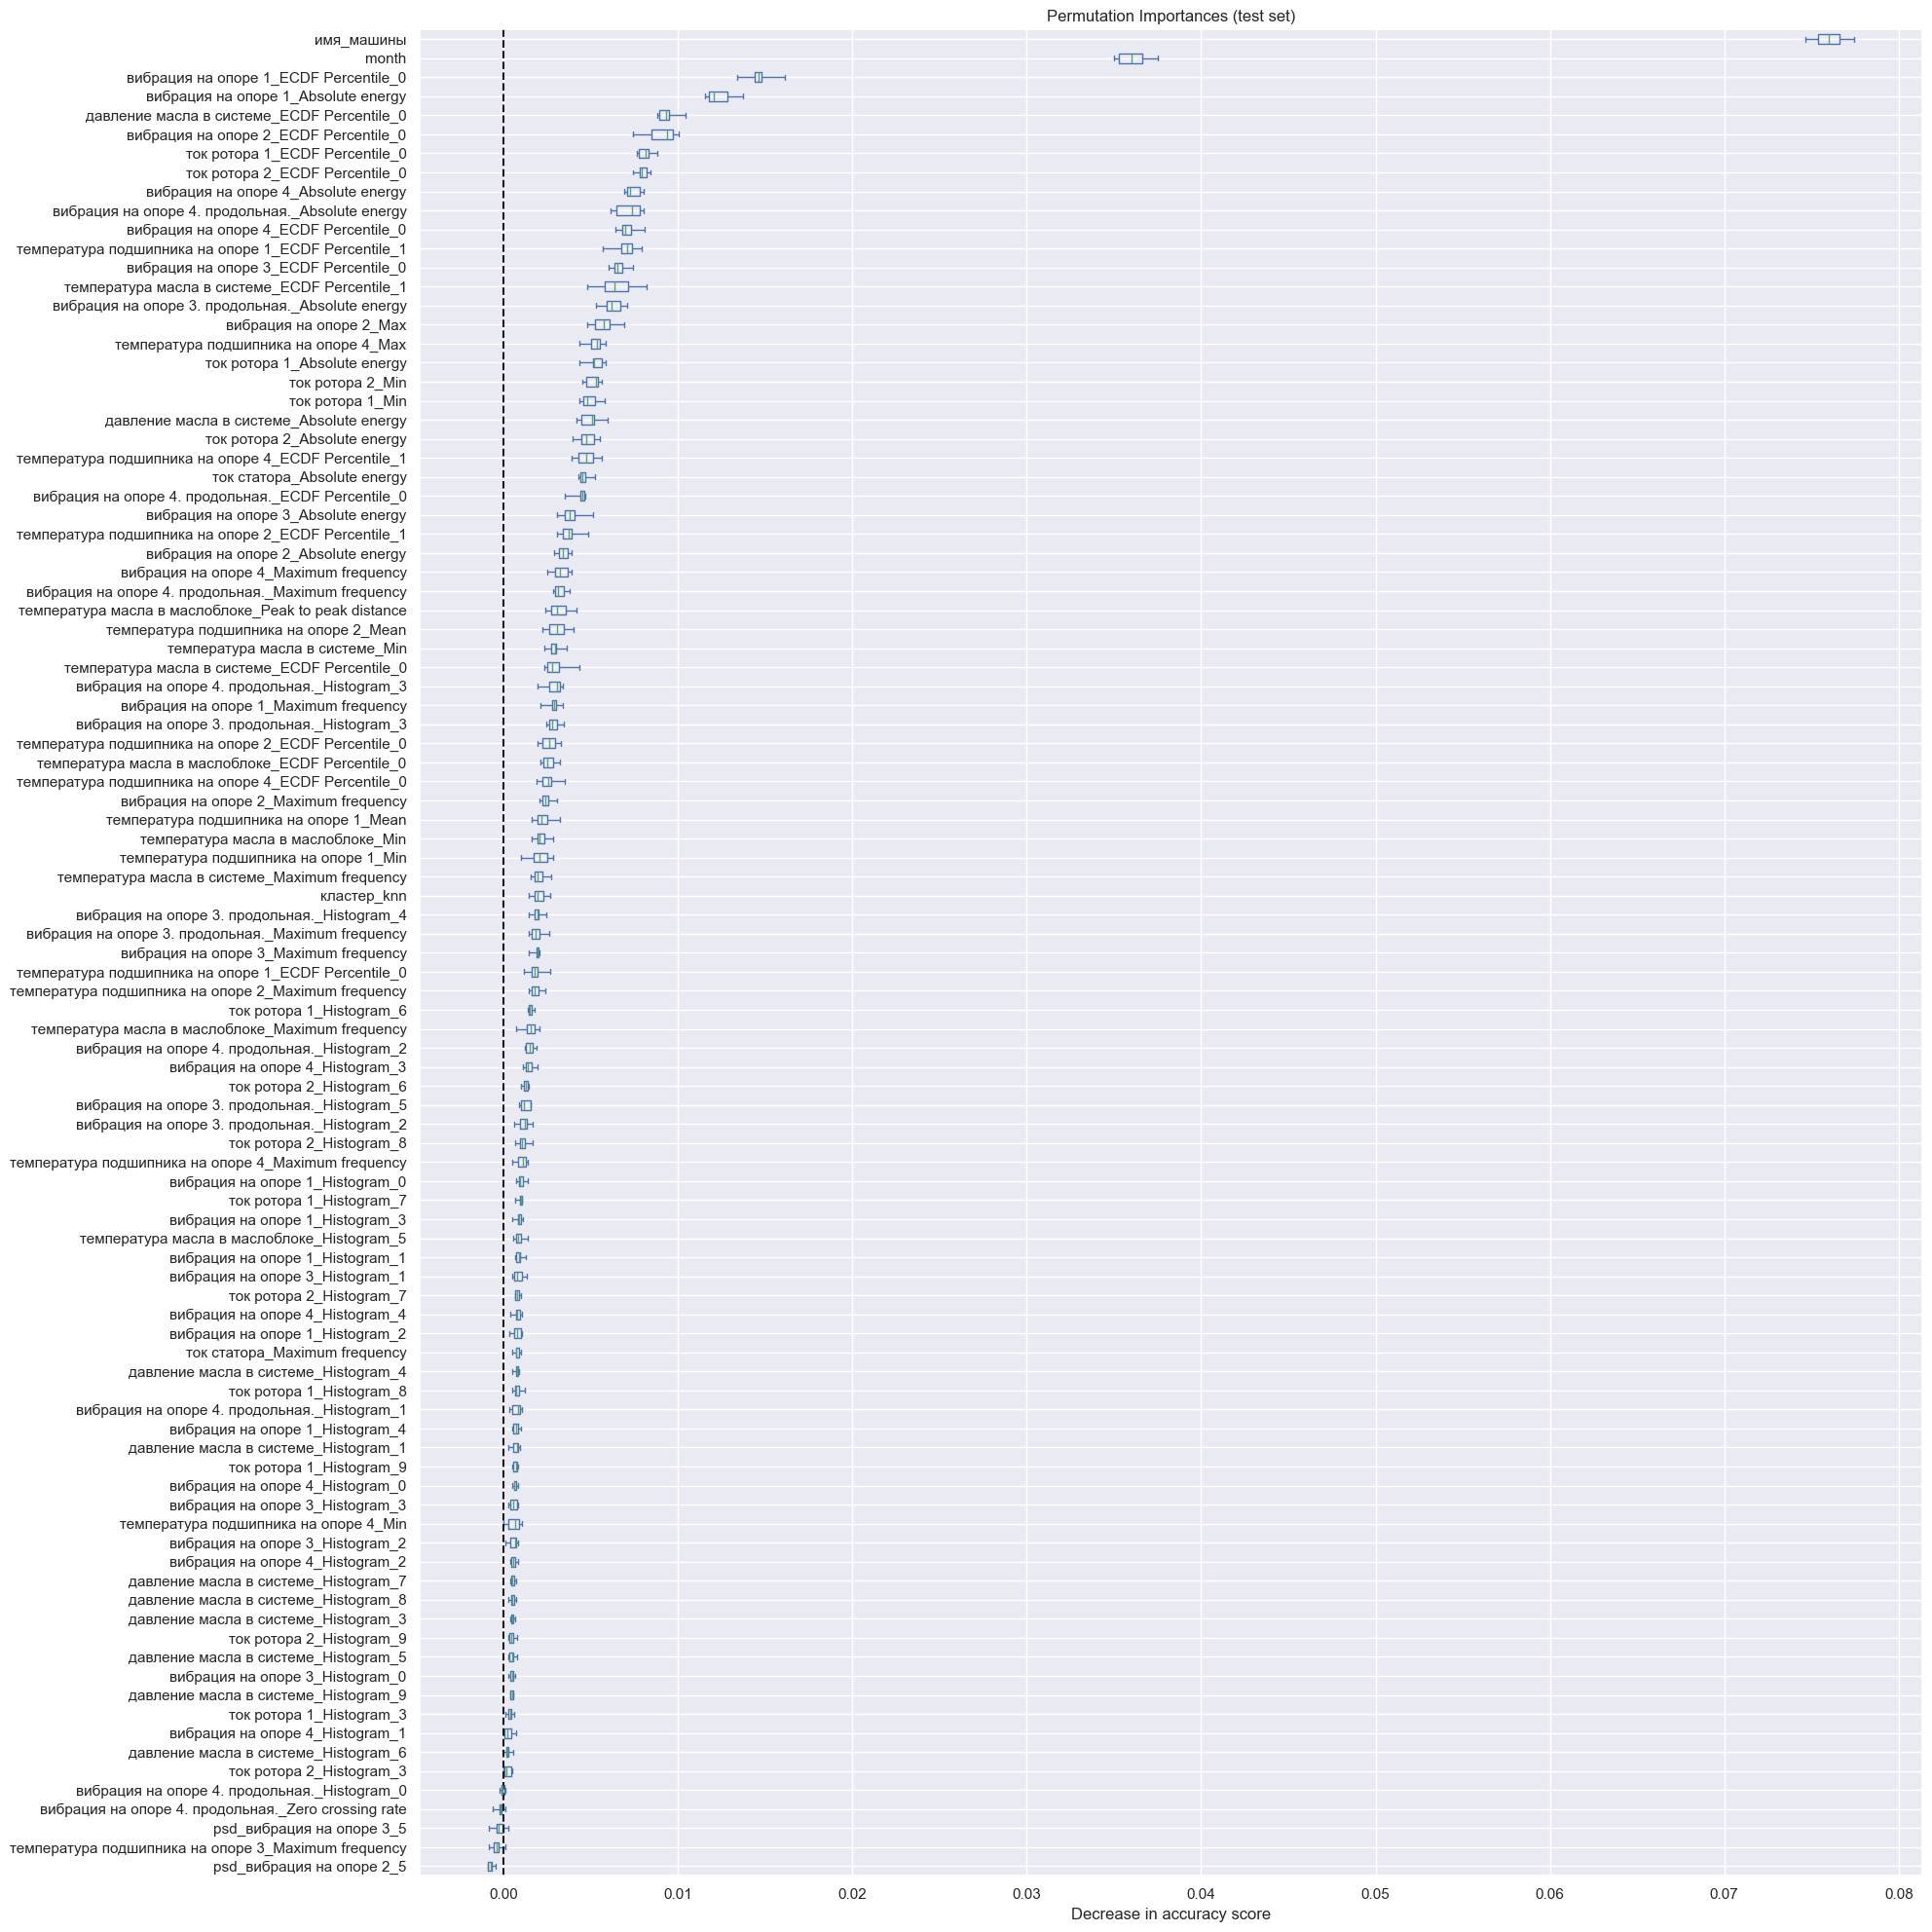

In [451]:
# importance_results = {key: [] for key in df_preproc_features.columns}

importance_res_class = permutation_importance(clf_2, X_test, y_test, n_repeats=10, random_state=SEED)
for key in importance_res_class:
    importance_res_class[key] = importance_res_class[key][clf_2['feature_selector'].get_support()]
importance_boxplot = plot_vert_boxplot(importance_res_class,
                                       selected_features,
                                       10,
                                       (20, 20))

In [557]:
models = {col: None for col in  y_train.columns}
importance_results = {key: [] for key in df_preproc_features.columns}

for col in  y_train.columns:
    clf = Pipeline(
        steps=[("preprocessor", numeric_transformer),
            ("feature_selector", feature_selector),
            ("classifier", RandomForestClassifier(n_estimators=500, min_samples_leaf=10, max_depth=20, class_weight='balanced', random_state=SEED))]
    )
    y_train_binary = y_train[col].copy()
    clf.fit(X_train, y_train_binary)
    models[col] = copy.deepcopy(clf)

In [577]:
models.keys()

dict_keys(['oil_equip', 'electric_equip_common', 'rotating', 'valves', 'bearings_mech', 'bearing_temp', 'static_equp', 'process', 'тр-р тм-6300-10/6', 'тр-р тм-4000-10/6'])

In [585]:
# importances_res = {col: None for col in  y_train.columns}
# importances_boxplot = {col: None for col in  y_train.columns}

for col in list(models.keys())[1:]:
    print(f"Class {col}")
    y_test_binary = y_test[col].copy()
    importances_res[col] = permutation_importance(models[col], X_test, y_test_binary, n_repeats=5, random_state=SEED)
    for key in importance_res_class:
        importances_res[col][key] = importances_res[col][key][clf['feature_selector'].get_support()]
    importances_boxplot[col] = plot_vert_boxplot(importances_res[col],
                                                selected_features,
                                                10,
                                                (10, 10))

Class electric_equip_common


Class oil_equip


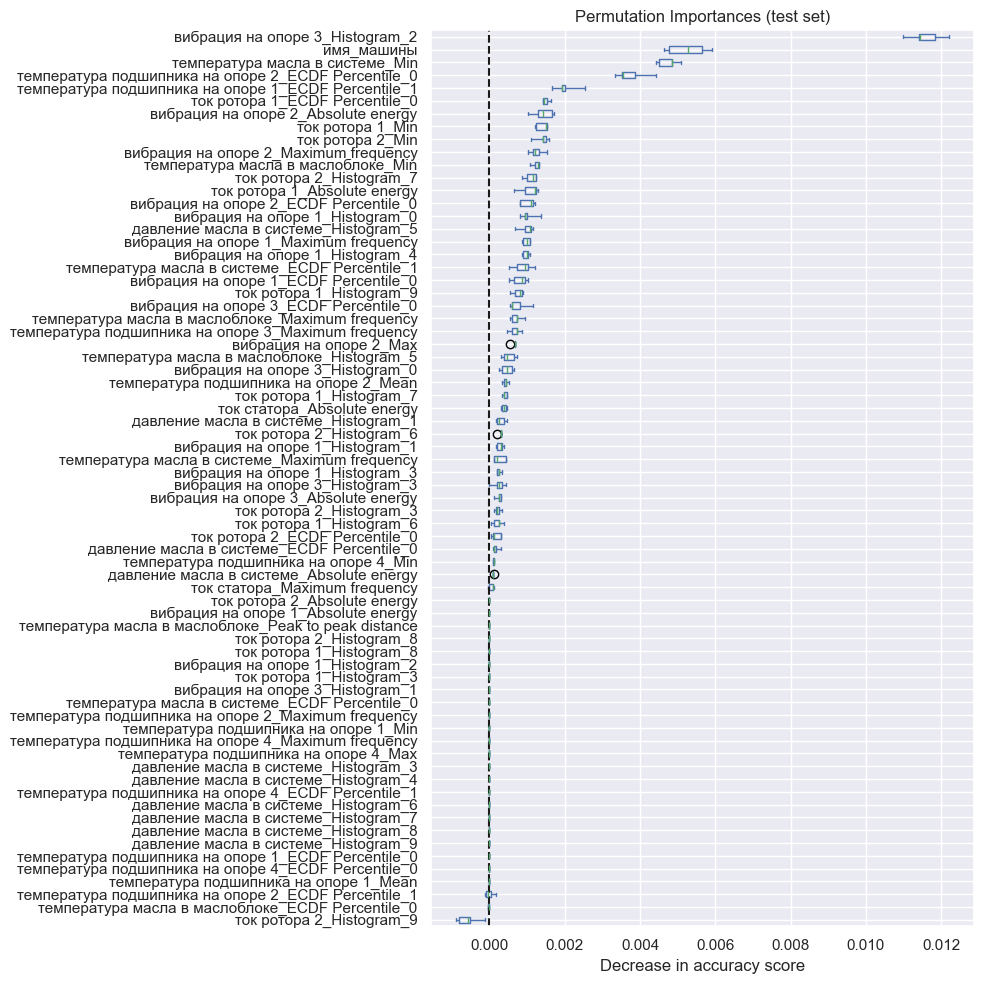

In [571]:
print(f"Class {col}")
importance_boxplot = plot_vert_boxplot(importances_res[col],
                                        selected_features,
                                        10,
                                        (10, 10))

---

In [468]:
df_predictions_all_1 = pd.DataFrame(predictions_all_1, index=df_target_grouped.index, columns=df_target_grouped.columns[:-1])
df_predictions_all_1[EQUIP_NAME] = df_target_grouped[EQUIP_NAME]

In [476]:
df_predictions_all_1.columns = df_predictions_all_1.columns + ["_pred"]

In [482]:
df_pred_target_knn =  pd.concat([df_predictions_all_1, df_target_grouped, df_preproc_features[CLUSTER_COL]], axis=1)
df_pred_target_knn.drop("имя_машины_pred", axis=1, inplace=True)

In [521]:
VISUAL_DATES = str(df_pred_target_knn.index.min()), str(df_pred_target_knn.index.max())
clusters = [CLUSTER_COL]
features = []
predictions = [
    'oil_equip_pred', 'electric_equip_common_pred', 'rotating_pred', 'valves_pred', 'bearings_mech_pred', 'bearing_temp_pred', 'static_equp_pred', 'process_pred', 'тр-р тм-6300-10/6_pred', 'тр-р тм-4000-10/6_pred', 
    'oil_equip', 'electric_equip_common', 'rotating', 'valves', 'bearings_mech', 'bearing_temp', 'static_equp', 'process', 'тр-р тм-6300-10/6', 'тр-р тм-4000-10/6']
y_plots = [clusters, predictions]
y_axis_names = ['кластер', 'prediction']
y_axis_map_names = [f"y{i}" for i in range(1, len(y_plots)+1)]
y_places = [0, 1.00]
plot_position = [0.10, 0.95]
colors = plt.get_cmap('rainbow', 20)
smooth_window = 10

for equip_name in EQUIP_NAMES:
    equip_name = int(equip_name[-1])
    savepath_plotly = PIC_EXPLORATORY_PATH / f"{equip_name}_pred_{VISUAL_DATES[0].replace(':', '-')}_{VISUAL_DATES[1].replace(':', '-')}.html"
    titles_plotly = {"title_text": f"Анализ работы агрегата эксгаустер {equip_name} за {VISUAL_DATES[0]}-{VISUAL_DATES[1]}",
                    "xaxis_title": DATETIME_COL}

    df_to_visual = df_pred_target_knn.loc[df_pred_target_knn[EQUIP_NAME] == equip_name, df_pred_target_knn.columns != EQUIP_NAME]
    df_to_visual = df_to_visual[(df_to_visual.index >= VISUAL_DATES[0]) & (df_to_visual.index <= VISUAL_DATES[1])].copy()

    plot_time_series(df_to_visual, y_axis_map_names, y_plots, y_axis_names, y_places, plot_position, titles_plotly, savepath_plotly, colors)

___

In [528]:
# search.fit(df_train_init, df_target_grouped)
# print("Best params:", search.best_params_)
# print("Best score:", search.best_score_)

clf.fit(X_train, y_train)
predictions_base = clf.predict(X_train)
predictions_base_test = clf.predict(X_test)

get_multilabel_report(y_test, predictions_base_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.98      0.99      0.98     14408
electric_equip_common       0.98      0.98      0.98     13608
             rotating       0.96      0.97      0.97      8298
               valves       0.99      0.97      0.98     14708
        bearings_mech       0.98      0.97      0.97     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.99      0.98      0.99     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       0.98      1.00      0.99      2527
    тр-р тм-4000-10/6       0.91      0.96      0.94       251

            micro avg       0.98      0.98      0.98     80430
            macro avg       0.78      0.78      0.78     80430
         weighted avg       0.98      0.98      0.98     80430
          samples avg       0.97      0.97      0.96     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



{'oil_equip': 0.97,
 'electric_equip_common': 0.97,
 'rotating': 0.93,
 'valves': 0.96,
 'bearings_mech': 0.95,
 'bearing_temp': 0.0,
 'static_equp': 0.97,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.98,
 'тр-р тм-4000-10/6': 0.88}

,A_P,A_N
P_P,8638,291
P_N,211,14197


,A_P,A_N
P_P,9500,229
P_N,213,13395


,A_P,A_N
P_P,14703,336
P_N,226,8072


,A_P,A_N
P_P,8417,212
P_N,368,14340


,A_P,A_N
P_P,12175,263
P_N,309,10590


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,7444,168
P_N,287,15438


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20766,44
P_N,0,2527


,A_P,A_N
P_P,23063,23
P_N,10,241


In [530]:
predictions_all = clf.predict(df_train_init)

df_predictions_all = pd.DataFrame(predictions_all, index=df_target_grouped.index, columns=df_target_grouped.columns[:-1])
df_predictions_all[EQUIP_NAME] = df_target_grouped[EQUIP_NAME]

df_predictions_all.columns = df_predictions_all.columns + ["_pred"]
df_pred_target_knn =  pd.concat([df_predictions_all, df_target_grouped, df_preproc_features[CLUSTER_COL]], axis=1)
df_pred_target_knn.drop("имя_машины_pred", axis=1, inplace=True)

In [531]:
VISUAL_DATES = str(df_pred_target_knn.index.min()), str(df_pred_target_knn.index.max())
clusters = [CLUSTER_COL]
features = []
predictions = [
    'oil_equip_pred', 'electric_equip_common_pred', 'rotating_pred', 'valves_pred', 'bearings_mech_pred', 'bearing_temp_pred', 'static_equp_pred', 'process_pred', 'тр-р тм-6300-10/6_pred', 'тр-р тм-4000-10/6_pred', 
    'oil_equip', 'electric_equip_common', 'rotating', 'valves', 'bearings_mech', 'bearing_temp', 'static_equp', 'process', 'тр-р тм-6300-10/6', 'тр-р тм-4000-10/6']
y_plots = [clusters, predictions]
y_axis_names = ['кластер', 'prediction']
y_axis_map_names = [f"y{i}" for i in range(1, len(y_plots)+1)]
y_places = [0, 1.00]
plot_position = [0.10, 0.95]
colors = plt.get_cmap('rainbow', 20)
smooth_window = 10

for equip_name in EQUIP_NAMES:
    equip_name = int(equip_name[-1])
    savepath_plotly = PIC_EXPLORATORY_PATH / "base" / f"{equip_name}_pred_{VISUAL_DATES[0].replace(':', '-')}_{VISUAL_DATES[1].replace(':', '-')}.html"
    titles_plotly = {"title_text": f"Анализ работы агрегата эксгаустер {equip_name} за {VISUAL_DATES[0]}-{VISUAL_DATES[1]}",
                    "xaxis_title": DATETIME_COL}

    df_to_visual = df_pred_target_knn.loc[df_pred_target_knn[EQUIP_NAME] == equip_name, df_pred_target_knn.columns != EQUIP_NAME]
    df_to_visual = df_to_visual[(df_to_visual.index >= VISUAL_DATES[0]) & (df_to_visual.index <= VISUAL_DATES[1])].copy()

    plot_time_series(df_to_visual, y_axis_map_names, y_plots, y_axis_names, y_places, plot_position, titles_plotly, savepath_plotly, colors)

----

In [550]:
n_iter = 20 # 100
# Scorer

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
    ]
)


feature_selector = SelectFromModel(ExtraTreesRegressor(min_samples_leaf=10, random_state=SEED)) # VarianceThreshold(.99 * (1 - .99)) # SelectFromModel(ExtraTreesRegressor(min_samples_leaf=10, random_state=SEED))
# feature_selector = PermutationImportance(LogisticRegression(penalty="l1", solver='liblinear'), scoring=cr_scorer, cv=None)

clf_4 = Pipeline(
    steps=[("preprocessor", numeric_transformer),
           ("feature_selector", feature_selector),
           ("classifier", RidgeClassifier(alpha=0.001, random_state=SEED))]
)

param_grid = {
    'classifier__alpha': [1e-3, 1e-2, 1e-1, 1], # np.linspace(-10, 10)
    'preprocessor__imputer__strategy':['median', 'mean']
}

cv_cls = 5 # StratifiedKFold(n_splits=5, shuffle=False)

search_2 = RandomizedSearchCV(clf_4,
                            param_grid, 
                            n_iter=n_iter,
                            verbose=True, 
                            n_jobs=-1,
                            cv=cv_cls, 
                            random_state=SEED)

clf_4

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('feature_selector',
                 SelectFromModel(estimator=ExtraTreesRegressor(min_samples_leaf=10,
                                                               random_state=42))),
                ('classifier', RidgeClassifier(alpha=0.001, random_state=42))])

In [549]:
search_2.fit(df_train_init, df_target_grouped.iloc[:,:-1])
print("Best params:", search_2.best_params_)
print("Best score:", search_2.best_score_)

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'preprocessor__imputer__strategy': 'median', 'classifier__alpha': 0.001}
Best score: 0.035814372027252864


In [551]:
clf_4.fit(X_train, y_train)
predictions_base = clf_4.predict(X_train)
predictions_base_test = clf_4.predict(X_test)

get_multilabel_report(y_test, predictions_base_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.63      0.87      0.73     14408
electric_equip_common       0.63      0.83      0.71     13608
             rotating       0.61      0.41      0.49      8298
               valves       0.72      0.87      0.79     14708
        bearings_mech       0.68      0.35      0.46     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.69      0.98      0.81     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       0.50      0.00      0.00      2527
    тр-р тм-4000-10/6       0.00      0.00      0.00       251

            micro avg       0.67      0.74      0.70     80430
            macro avg       0.45      0.43      0.40     80430
         weighted avg       0.66      0.74      0.67     80430
          samples avg       0.66      0.74      0.67     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



{'oil_equip': 0.58,
 'electric_equip_common': 0.55,
 'rotating': 0.32,
 'valves': 0.65,
 'bearings_mech': 0.3,
 'bearing_temp': 0.0,
 'static_equp': 0.68,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.0,
 'тр-р тм-4000-10/6': 0.0}

,A_P,A_N
P_P,1562,7367
P_N,1821,12587


,A_P,A_N
P_P,3082,6647
P_N,2381,11227


,A_P,A_N
P_P,12879,2160
P_N,4935,3363


,A_P,A_N
P_P,3583,5046
P_N,1882,12826


,A_P,A_N
P_P,10653,1785
P_N,7065,3834


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,875,6737
P_N,383,15342


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20806,4
P_N,2523,4


,A_P,A_N
P_P,23086,0
P_N,251,0


In [553]:
X_train, X_test, y_train, y_test = train_test_split(df_preproc_features, df_target_grouped,
                                                    test_size=0.3,
                                                    random_state=SEED,
                                                    stratify=df_target_wide.loc[:, df_target_wide.columns != EQUIP_NAME])
y_train, y_test = y_train.iloc[:,:-1], y_test.iloc[:,:-1]

In [554]:
clf_4.fit(X_train, y_train)
predictions_base = clf_4.predict(X_train)
predictions_base_test = clf_4.predict(X_test)

get_multilabel_report(y_test, predictions_base_test, df_target_grouped.columns[:-1])

                       precision    recall  f1-score   support

            oil_equip       0.80      0.86      0.83     14408
electric_equip_common       0.80      0.85      0.82     13608
             rotating       0.75      0.57      0.65      8298
               valves       0.77      0.87      0.82     14708
        bearings_mech       0.73      0.66      0.69     10899
         bearing_temp       0.00      0.00      0.00         2
          static_equp       0.79      0.91      0.85     15725
              process       0.00      0.00      0.00         4
    тр-р тм-6300-10/6       0.93      0.85      0.89      2527
    тр-р тм-4000-10/6       1.00      0.02      0.03       251

            micro avg       0.78      0.81      0.80     80430
            macro avg       0.66      0.56      0.56     80430
         weighted avg       0.78      0.81      0.79     80430
          samples avg       0.78      0.81      0.77     80430



c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\Users\parshin_sa2\Miniconda3\envs\pm-rotating-equip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



{'oil_equip': 0.71,
 'electric_equip_common': 0.7,
 'rotating': 0.48,
 'valves': 0.69,
 'bearings_mech': 0.53,
 'bearing_temp': 0.0,
 'static_equp': 0.74,
 'process': 0.0,
 'тр-р тм-6300-10/6': 0.8,
 'тр-р тм-4000-10/6': 0.02}

,A_P,A_N
P_P,5831,3098
P_N,2028,12380


,A_P,A_N
P_P,6848,2881
P_N,2031,11577


,A_P,A_N
P_P,13489,1550
P_N,3590,4708


,A_P,A_N
P_P,4797,3832
P_N,1847,12861


,A_P,A_N
P_P,9713,2725
P_N,3668,7231


,A_P,A_N
P_P,23335,0
P_N,2,0


,A_P,A_N
P_P,3904,3708
P_N,1399,14326


,A_P,A_N
P_P,23333,0
P_N,4,0


,A_P,A_N
P_P,20636,174
P_N,375,2152


,A_P,A_N
P_P,23086,0
P_N,247,4
